# Inference of hierarchical Gaussian model parameters

In [334]:
import arviz as az
import chi
import matplotlib.pyplot as plt
import numpy as np
import pints
import scipy.stats
import seaborn as sns
import xarray as xr
sns.set_theme()

import jax.numpy as jnp
from jax import grad

The data-generating distribution is
$$
    y \sim p(\cdot | \mu _{\mathrm{pop}}) =
    \int \mathrm{d}\mu \, \mathcal{N}(y | \mu, 1)\,
    \mathcal{N}(\mu | \mu _{\mathrm{pop}}, 1)
$$

Due to the conjugacy of Gaussian distributions, the hierarchical distribution
can be computed exactly to be

$$
    y \sim \mathcal{N}(\cdot | \mu _{\mathrm{pop}}, 2).
$$

Together with
a Gaussian prior $\mu _{\mathrm{pop}} \sim \mathcal{N}(\cdot | \mu _0 = 0, \sigma _0^2 = 16)$, we
can also use the conjugacy to compute the posterior
distribution analytically
$$
    p(\mu _{\mathrm{pop}} | \mathcal{D}) =
        \mathcal{N}(\mu _{\mathrm{pop}} | \mu ', \sigma '^2 ),
$$
where
$$
    \mu' = \sigma '^2\frac{n\bar{y}}{2},
    \quad
    \sigma '^2 = \frac{16}{1 + 8n}.
$$
Here, $n$ is the number of snapshot observations in the dataset
$\mathcal{D}=\{y_j^{\mathrm{obs}}\}$ and $\bar{y}$ denotes the empirical mean,
$\bar{y} = \sum _j y_j^{\mathrm{obs}} / n$.

# Synthesise data

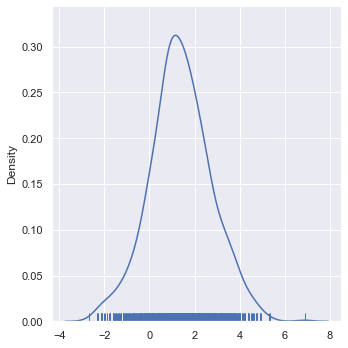

In [5]:
np.random.seed(42)
n_ids = 1000
n_samples_per_id = 1
true_parameters = [1.3, 1, 1]  # pop mean, pop std., noise
means = np.random.normal(
    loc=true_parameters[0], scale=true_parameters[1], size=n_ids)
data = np.empty(shape=(n_ids, n_samples_per_id))
for ids, mean in enumerate(means):
    data[ids] = np.random.normal(
    loc=mean, scale=true_parameters[2], size=n_samples_per_id)

sns.displot(data.flatten(), kind='kde', rug=True)
plt.show()

## Define log-likelihoods

1. Exact Gaussian log-likelihood
2. Gaussian filter log-likelihood
3. Gaussian KDE filter log-likelihood
4. Gaussian KDE filter log-likelihood with rank matching 
4. Data-centric KDE filter log-likelihood

In [350]:
class ExactHierarchicalLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations):
        self._observations = observations
        self._n_ids, self._n_obs = observations.shape
        self._error_model = chi.GaussianErrorModel()
        self._pop_model = chi.GaussianModel()

    def __call__(self, parameters):
        # Compute population contribution
        means = parameters[:self._n_ids]
        pop_mean = parameters[self._n_ids]
        pop_sigma, sigma = [1, 1]
        score = np.sum(
            scipy.stats.norm(loc=pop_mean, scale=pop_sigma).logpdf(
                means))
        if np.isinf(score):
            return score

        # Compute contributions from individual log-likelihoods
        for _id, mean in enumerate(means):
            score += np.sum(
            scipy.stats.norm(loc=mean, scale=sigma).logpdf(
                self._observations[_id]))

        return score

    def evaluateS1(self, parameters):
        # Compute population contribution
        means = np.array(parameters[:self._n_ids])
        pop_mean = parameters[self._n_ids]
        pop_sigma, sigma = [1, 1]
        score, pop_sens = self._pop_model.compute_sensitivities(
            parameters=[pop_mean, pop_sigma], observations=means)

        # Compute individual contributions
        sensitivities = np.zeros(self.n_parameters())
        for _id, indiv_obs in enumerate(self._observations):
            s, sens = self._error_model.compute_sensitivities(
                parameters=[sigma],
                model_output=np.array([means[_id]] * self._n_obs),
                model_sensitivities=np.ones(shape=(self._n_obs, 1)),
                observations=indiv_obs)

            score += s
            sensitivities[_id] += sens[0]

        # Add population sensitivities
        sensitivities += pop_sens[:-1]

        return score, sensitivities

    def n_parameters(self):
        return self._n_ids + 1

    def get_parameter_names(self):
        return ['Mean'] * self._n_ids + ['Pop. mean']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_ids)] + [None]


class GaussianFilterLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, n_samples=10):
        self._observations = np.array(observations).flatten()
        self._n_samples = int(n_samples)
        self._normal = chi.GaussianErrorModel()

    def __call__(self, parameters):
        standard_mean_samples = np.array(
            parameters[:self._n_samples])[:, np.newaxis]
        standard_noise_samples = np.array(
            parameters[self._n_samples:2*self._n_samples])[np.newaxis, :]
        pop_mean = parameters[-1]
        pop_std, sigma = [1, 1]

        # Compute measurements
        mean_samples = pop_mean + standard_mean_samples * pop_std
        measurements = mean_samples + sigma * standard_noise_samples

        # Estimate population mean and population std from samples
        pop_mu = np.mean(measurements)
        pop_sigma = np.std(measurements, ddof=1)
        score = np.sum(
            scipy.stats.norm(loc=pop_mu, scale=pop_sigma).logpdf(
                self._observations))

        if np.isnan(score):
            return -np.inf

        return score

    def evaluateS1(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu = parameters[-1]
        pop_sigma, sigma = [1, 1]

        # Compute measurements
        mean_samples = pop_mu + eta * pop_sigma
        measurements = mean_samples + sigma * epsilon

        # Estimate population mean and population std from samples
        pop_mu_hat = np.mean(measurements)
        pop_sigma_hat = np.std(measurements, ddof=1)

        # Compute sensitivities of pop_mu and pop_sigma to parameters
        dpop_mu_hat_deta = pop_sigma / self._n_samples
        dpop_mu_hat_depsilon = sigma / self._n_samples
        dpop_mu_hat_dpop_mu = 1
        dpop_mu_hat_dpop_sigma = np.mean(eta)
        dpop_sigma_hat_deta = \
            pop_sigma * (measurements - pop_mu_hat) / (self._n_samples - 1) \
            / pop_sigma_hat
        dpop_sigma_hat_depsilon = \
            sigma * (measurements - pop_mu_hat) / (self._n_samples - 1) / \
            pop_sigma_hat
        dpop_sigma_hat_dpop_mu = 0

        # Estimate likelihood with Gaussian KDE and compute associated
        # sensitivities
        n_obs = len(self._observations)
        model_sensitivities = np.broadcast_to(np.hstack([
            dpop_mu_hat_deta,
            dpop_mu_hat_depsilon,
            dpop_mu_hat_dpop_mu,
            dpop_mu_hat_dpop_sigma]), shape=(n_obs, 4))
        score, sens = self._normal.compute_sensitivities(
            parameters=[pop_sigma_hat],
            model_output=np.array([pop_mu_hat] * n_obs),
            model_sensitivities=model_sensitivities,
            observations=self._observations)

        # Compute final sensitivities
        # dp/deta =
        #   dp/dpop_mu_hat * dpop_mu_hat/deta +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/deta
        # dp/depsilon =
        #   dp/dpop_mu_hat * dpop_mu_hat/depsilon +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/depsilon
        # dp/dpop_mu =
        #   dp/dpop_mu_hat * dpop_mu_hat/dpop_mu +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/dpop_mu
        # dp/dpop_sigma =
        #   dp/dpop_mu_hat * dpop_mu_hat/dpop_sigma +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/dpop_sigma
        sensitivities = np.zeros(shape=self.n_parameters())
        sensitivities[:self._n_samples] = \
            sens[0] + sens[-1] * dpop_sigma_hat_deta
        sensitivities[self._n_samples:2*self._n_samples] = \
            sens[1] + sens[-1] * dpop_sigma_hat_depsilon
        sensitivities[2*self._n_samples] = \
            sens[2] + sens[-1] * dpop_sigma_hat_dpop_mu

        return score, sensitivities

    def n_parameters(self):
        return 2 * self._n_samples + 1

    def get_parameter_names(self):
        return [
            'Mean eta' for _ in range(self._n_samples)] + [
            'Epsilon' for _ in range(self._n_samples)] + ['Pop. mean']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_samples)] * 2 + [None]


class GaussianKDEFilterLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, n_samples=1000, kernel_scale=None):
        self._observations = observations.flatten()
        self._n_samples = int(n_samples)
        self._normal = chi.GaussianErrorModel()

        # Set kernel scale
        # (If None or non-positive use Scott's rule of thumb (like scipy))
        if (not kernel_scale) or (kernel_scale <=0):
            kernel_scale = \
                np.std(observations, ddof=1) \
                * (4 / 3 / self._n_samples) ** (0.2)
        self._kernel_scale = kernel_scale

    def __call__(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu = parameters[-1]
        pop_sigma, sigma = [1, 1]

        # Compute mean measurements and kernel sizes
        # (use conjugacy of Gaussian error model and Gaussian kernel)
        mean_samples = pop_mu + eta * pop_sigma
        measurements = mean_samples + sigma * epsilon

        # Estimate log-likelihood as the mean across kdes
        score = np.sum(scipy.special.logsumexp(
            - np.log(2 * np.pi) / 2 - np.log(self._kernel_scale) - (
                measurements[np.newaxis, :] -
                self._observations[:, np.newaxis])**2 \
            / self._kernel_scale**2 / 2, axis=1) - np.log(self._n_samples))

        return score

    def evaluateS1(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu = parameters[-1]
        pop_sigma, sigma = [1, 1]

        # Compute mean measurements and kernel sizes
        # (use conjugacy of Gaussian error model and Gaussian kernel)
        mean_samples = pop_mu + eta * pop_sigma
        measurements = mean_samples + sigma * epsilon

        # Estimate log-likelihood as the mean across kdes
        scores = \
            - np.log(2 * np.pi) / 2 - np.log(self._kernel_scale) - (
                measurements[np.newaxis, :] -
                self._observations[:, np.newaxis])**2 \
            / self._kernel_scale**2 / 2
        score = np.sum(
            scipy.special.logsumexp(scores, axis=1) - np.log(self._n_samples))

        # Collect sensitivities
        # p = log mean exp scores
        # dp/dmean = exp(score) / sum(exp(scores)) * dscore / dmean
        # dp/depsilon = exp(score) / sum(exp(scores)) * dscore / depsilon
        # dp/dpop_mean = exp(score) / sum(exp(scores)) * dscore / dpop_mean
        softmax = \
            np.exp(scores - np.max(scores, axis=1)[:, np.newaxis]) / np.sum(
            np.exp(scores - np.max(scores, axis=1)[:, np.newaxis]),
            axis=1)[:, np.newaxis]

        sensitivities = np.zeros(shape=self.n_parameters())
        sensitivities[:self._n_samples] = \
            - pop_sigma / self._kernel_scale**2 * np.sum(
                (measurements[np.newaxis, :] -
                self._observations[:, np.newaxis]) *
                softmax,
                axis=0)
        sensitivities[self._n_samples:2*self._n_samples] = \
            - sigma / self._kernel_scale**2 * np.sum(
                (measurements[np.newaxis, :] -
                self._observations[:, np.newaxis]) *
                softmax,
                axis=0)
        sensitivities[2*self._n_samples] = \
            - 1 / self._kernel_scale**2 * np.sum(
                (measurements[np.newaxis, :] -
                self._observations[:, np.newaxis]) *
                softmax)

        return score, sensitivities

    def n_parameters(self):
        return 2 * self._n_samples + 1

    def get_parameter_names(self):
        return ['Mean eta'] * self._n_samples + [
            'Epsilon'] * self._n_samples + ['Pop. mean']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_samples)] * 2 + [None]


class RankMatchingGaussianKDEFilterLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, n_samples=1000):
        # Make sure n_obs is a multiple of n_samples
        n_samples = int(n_samples)
        if len(observations) % n_samples != 0:
            raise ValueError(
                'n_samples has to be a divisor of n_observations.')

        # Rank observations and rearrange into blocks of n_obs / n_samples
        n_block = int(len(observations) / n_samples)
        self._observations = np.sort(observations.flatten()).reshape(
            (n_samples, n_block))
        self._n_samples = n_samples

        # Set kernel scale
        # (Each block gets its own kernel)
        kernel_scale = np.zeros(n_samples)
        if len(observations) > n_samples:
            kernel_scale = \
                np.std(self._observations, ddof=1, axis=1) \
                * (4 / 3) ** (0.2)
        self._kernel_scale = kernel_scale[:, np.newaxis]

    def __call__(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        pop_mu = parameters[-1]
        pop_sigma, sigma = [1, 1]

        # Compute mean measurements and kernel sizes
        # (use conjugacy of Gaussian error model and Gaussian kernel)
        mean_samples = pop_mu + eta * pop_sigma
        measurements = mean_samples

        # Estimate log-likelihood as the mean across kdes
        kernel_var = sigma**2 + self._kernel_scale**2
        score = np.sum(
            - np.log(2 * np.pi) / 2 - np.log(kernel_var) / 2 - (
                measurements[:, np.newaxis] - self._observations)**2 \
            / kernel_var / 2)

        return score

    def evaluateS1(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        pop_mu = parameters[-1]
        pop_sigma, sigma = [1, 1]

        # Compute mean measurements and kernel sizes
        # (use conjugacy of Gaussian error model and Gaussian kernel)
        mean_samples = pop_mu + eta * pop_sigma
        measurements = mean_samples

        # Estimate log-likelihood as the mean across kdes
        kernel_var = sigma**2 + self._kernel_scale**2
        score = np.sum(
            - np.log(2 * np.pi) / 2 - np.log(kernel_var) / 2 - (
                measurements[:, np.newaxis] - self._observations)**2 \
            / kernel_var / 2)

        # Collect sensitivities
        sensitivities = np.zeros(shape=self.n_parameters())
        sensitivities[:self._n_samples] = \
            - np.sum(pop_sigma / kernel_var *
                (measurements[:, np.newaxis] - self._observations), axis=1)
        sensitivities[self._n_samples] = \
            -  np.sum(1 / kernel_var *
                (measurements[:, np.newaxis] - self._observations))

        return score, sensitivities

    def n_parameters(self):
        return self._n_samples + 1

    def get_parameter_names(self):
        return ['Mean eta'] * self._n_samples + ['Pop. mean']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_samples)] + [None]


class AnchorKDELogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, n_anchors=1, n_samples=100):
        if (n_anchors - 1) > n_samples:
            raise ValueError(
                'The implementation requires at least one more sample than '
                'anchors.')

        self._observations = observations.flatten()[np.newaxis, :]
        self._n_samples = int(n_samples)
        self._n_anchors = int(n_anchors)
        self._normal = chi.GaussianErrorModel()

        # Set kernel scale
        kernel_scale = \
            np.std(observations, ddof=1) \
            * (4 / 3 / self._n_anchors) ** (0.2)
        self._kernel_scale = kernel_scale

    def __call__(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = parameters[:self._n_samples]
        epsilon = parameters[self._n_samples:2*self._n_samples]
        pop_mu = parameters[2*self._n_samples]
        pop_sigma, sigma = [1, 1]

        # Compute mean measurements
        mean_samples = pop_mu + eta * pop_sigma
        measurements = mean_samples + sigma * epsilon

        # Use first n_anchors measurements as KDE anchors
        anchors = measurements[:self._n_anchors]
        measurements = measurements[self._n_anchors:]

        # Add dummy dimensions for broadcasting
        anchors = anchors[:, np.newaxis]
        measurements = measurements[np.newaxis, :]

        # Compute log-likelihood of anchors
        score = np.sum(scipy.special.logsumexp(
            - np.log(2 * np.pi) / 2 - np.log(self._kernel_scale) - (
                anchors - self._observations)**2 \
            / self._kernel_scale**2 / 2, axis=0) - np.log(self._n_anchors))

        # Compute log-likelihood of samples measurements
        if self._n_samples > self._n_anchors:
            score += np.sum(scipy.special.logsumexp(
                - np.log(2 * np.pi) / 2 - np.log(self._kernel_scale) - (
                    anchors - measurements)**2 \
                / self._kernel_scale**2 / 2, axis=0) - np.log(self._n_anchors))

        return score

    def evaluateS1(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = parameters[:self._n_samples]
        epsilon = parameters[self._n_samples:2*self._n_samples]
        pop_mu = parameters[2*self._n_samples]
        pop_sigma, sigma = [1, 1]

        # Compute mean measurements
        mean_samples = pop_mu + eta * pop_sigma
        measurements = mean_samples + sigma * epsilon

        # Use first n_anchors measurements as KDE anchors
        anchors = measurements[:self._n_anchors]
        measurements = measurements[self._n_anchors:]

        # Add dummy dimensions for broadcasting
        anchors = anchors[:, np.newaxis]
        measurements = measurements[np.newaxis, :]

        # Compute log-likelihood of anchors
        scores_obs = \
            - np.log(2 * np.pi) / 2 - np.log(self._kernel_scale) \
            - (anchors - self._observations)**2 / self._kernel_scale**2 / 2
        score = \
            np.sum(scipy.special.logsumexp(scores_obs, axis=0) \
            - np.log(self._n_anchors))

        # Compute log-likelihood of samples measurements
        scores_sim = \
            - np.log(2 * np.pi) / 2 - np.log(self._kernel_scale) \
            - (anchors - measurements)**2 / self._kernel_scale**2 / 2
        score += \
            np.sum(scipy.special.logsumexp(scores_sim, axis=0) \
            - np.log(self._n_anchors))

        # Collect sensitivities
        sensitivities = np.zeros(shape=self.n_parameters())
        scores_obs -= np.max(scores_obs, axis=0)[np.newaxis, :]
        softmax_obs = \
            np.exp(scores_obs) / np.sum(np.exp(scores_obs), axis=0)[
                np.newaxis, :]
        scores_sim -= np.max(scores_sim, axis=0)[np.newaxis, :]
        softmax_sim = \
            np.exp(scores_sim) / np.sum(np.exp(scores_sim), axis=0)[
                np.newaxis, :]

        sensitivities[:self._n_anchors] = \
            pop_sigma * np.sum(1 / self._kernel_scale**2
            * (self._observations - anchors) * softmax_obs, axis=1) \
            + pop_sigma * np.sum(1 / self._kernel_scale**2
            * (measurements - anchors) * softmax_sim, axis=1)
        sensitivities[self._n_anchors:self._n_samples] = \
            pop_sigma * np.sum(1 / self._kernel_scale**2
            * (anchors - measurements) * softmax_sim, axis=0)
        sensitivities[self._n_samples:self._n_samples+self._n_anchors] = \
            sigma * np.sum(1 / self._kernel_scale**2
            * (self._observations - anchors) * softmax_obs, axis=1) \
            + sigma * np.sum(1 / self._kernel_scale**2
            * (measurements - anchors) * softmax_sim, axis=1)
        sensitivities[self._n_samples+self._n_anchors:2*self._n_samples] = \
            - sigma * np.sum(1 / self._kernel_scale**2
            * (measurements - anchors) * softmax_sim, axis=0)
        sensitivities[2*self._n_samples] = \
            pop_sigma * np.sum(1 / self._kernel_scale**2
            * (anchors - measurements) * softmax_sim) \
            + pop_sigma * np.sum(1 / self._kernel_scale**2
            * (self._observations - anchors) * softmax_obs) \
            + pop_sigma * np.sum(1 / self._kernel_scale**2
            * (measurements - anchors) * softmax_sim)

        return score, sensitivities

    def n_anchors(self):
        return self._n_anchors

    def n_parameters(self):
        return 2 * self._n_samples + 1

    def get_parameter_names(self):
        return ['Mu eta'] * self._n_samples + [
            'Epsilon'] * self._n_samples + ['Pop. mu']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_samples)] * 2 + [None]


class OldAnchorKDELogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, anchor_size=100, n_samples=100):
        # Check that data can be cleanly parsed into block
        observations = observations.flatten()
        n_obs = len(observations)
        anchor_size = int(anchor_size)
        if n_obs % (anchor_size / 2) != 0:
            raise ValueError(
                'n_obs is not a multiple of anchor_size / 2')

        # Rank observations and parse into overlapping blocks
        block_shift = int(anchor_size / 2)
        n_anchors = int(n_obs / anchor_size + 1)
        observations = np.sort(observations)
        obs = np.empty(shape=(n_anchors, anchor_size))
        for block_id in range(n_anchors):
            obs[block_id] = observations[
                block_id*block_shift:
                block_id*block_shift+anchor_size]
        self._observations = obs
        self._overcounting = 0.5

        self._n_anchors = n_anchors
        self._n_samples = int(n_samples)

    def __call__(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])[np.newaxis, :]
        epsilon = np.array(
            parameters[self._n_samples:2*self._n_samples])[np.newaxis, :]
        anchor_eta = np.array(
            parameters[2*self._n_samples:2*self._n_samples+self._n_anchors]
            )[:, np.newaxis]
        anchor_sigma = np.array(parameters[
            2*self._n_samples+self._n_anchors:
            2*self._n_samples+2*self._n_anchors])[:, np.newaxis]
        pop_mu = parameters[2*self._n_samples+2*self._n_anchors]
        pop_sigma, sigma = [1, 1]

        # Compute mean measurements
        mean_samples = pop_mu + eta * pop_sigma
        measurements = mean_samples + sigma * epsilon

        # Copmute anchors
        anchors = pop_mu + anchor_eta * pop_sigma

        # Compute log-likelihood of anchors
        score = self._overcounting * np.sum(
            - np.log(2 * np.pi) / 2 - np.log(anchor_sigma) - (
                anchors - self._observations)**2 \
            / anchor_sigma**2 / 2)

        # Compute log-likelihood of samples measurements
        score += np.sum(scipy.special.logsumexp(
            - np.log(2 * np.pi) / 2 - np.log(anchor_sigma) - (
                anchors - measurements)**2 \
            / anchor_sigma**2 / 2, axis=0) - np.log(self._n_anchors))

        return score

    def evaluateS1(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])[np.newaxis, :]
        epsilon = np.array(
            parameters[self._n_samples:2*self._n_samples])[np.newaxis, :]
        anchor_eta = np.array(
            parameters[2*self._n_samples:2*self._n_samples+self._n_anchors]
            )[:, np.newaxis]
        anchor_sigma = np.array(parameters[
            2*self._n_samples+self._n_anchors:
            2*self._n_samples+2*self._n_anchors])[:, np.newaxis]
        pop_mu = parameters[2*self._n_samples+2*self._n_anchors]
        pop_sigma, sigma = [1, 1]

        # Compute mean measurements
        mean_samples = pop_mu + eta * pop_sigma
        measurements = mean_samples + sigma * epsilon

        # Copmute anchors
        anchors = pop_mu + anchor_eta * pop_sigma

        # Compute log-likelihood of anchors
        score = self._overcounting * np.sum(
            - np.log(2 * np.pi) / 2 - np.log(anchor_sigma) - (
                anchors - self._observations)**2 \
            / anchor_sigma**2 / 2)

        # Compute log-likelihood of samples measurements
        scores = \
            - np.log(2 * np.pi) / 2 - np.log(anchor_sigma) \
            - (anchors - measurements)**2 / anchor_sigma**2 / 2
        score += \
            np.sum(scipy.special.logsumexp(scores, axis=0) \
            - np.log(self._n_anchors))

        # Collect sensitivities
        sensitivities = np.zeros(shape=self.n_parameters())
        scores -= np.max(scores, axis=0)[np.newaxis, :]
        softmax = \
            np.exp(scores) / np.sum(np.exp(scores), axis=0)[np.newaxis, :]

        sensitivities[:self._n_samples] = \
            pop_sigma * np.sum(1 / anchor_sigma**2
            * (anchors - measurements) * softmax, axis=0)
        sensitivities[self._n_samples:2*self._n_samples] = \
            - sigma * np.sum(1 / anchor_sigma**2
            * (measurements - anchors) * softmax, axis=0)
        sensitivities[2*self._n_samples:2*self._n_samples+self._n_anchors] = \
            pop_sigma * self._overcounting * np.sum(1 / anchor_sigma**2 \
            * (self._observations - anchors), axis=1) \
            + pop_sigma * np.sum(1 / anchor_sigma**2
            * (measurements - anchors) * softmax, axis=1)
        sensitivities[
                2*self._n_samples+self._n_anchors:
                2*self._n_samples+2*self._n_anchors] = \
            self._overcounting \
            * np.sum(-1 / anchor_sigma + 1 / anchor_sigma**3 \
            * (anchors - self._observations)**2, axis=1) \
            + np.sum((-1 / anchor_sigma + 1 / anchor_sigma**3 \
            * (anchors - measurements)**2) * softmax, axis=1)
        sensitivities[2*self._n_samples+2*self._n_anchors] = \
            np.sum(1 / anchor_sigma**2
            * (anchors - measurements) * softmax) \
            + self._overcounting * np.sum(1 / anchor_sigma**2 \
            * (self._observations - anchors)) \
            + np.sum(1 / anchor_sigma**2
            * (measurements - anchors) * softmax)

        return score, sensitivities

    def n_anchors(self):
        return self._n_anchors

    def n_parameters(self):
        return 2 * self._n_samples + 2 * self._n_anchors + 1

    def get_parameter_names(self):
        return ['Mu eta'] * self._n_samples + [
            'Epsilon'] * self._n_samples + [
            'Anchor mu %d' % ida for ida in range(self._n_anchors)] + [
            'Anchor sigma %d' % ida for ida in range(self._n_anchors)] + [
            'Pop. mu']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_samples)] * 2 + [
            None] * (2 * self._n_anchors + 1)


class GaussianDataLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, n_samples=10):
        observations = np.array(observations).flatten()
        self._mean = np.mean(observations)
        self._std = np.std(observations, ddof=1)
        self._n_samples = int(n_samples)
        self._normal = chi.GaussianErrorModel()

    def __call__(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu = parameters[-1]
        pop_sigma, sigma = [1, 1]

        # Compute measurements
        mean_samples = pop_mu + eta * pop_sigma
        measurements = mean_samples + sigma * epsilon

        # Compute log-likelihood
        score = np.sum(
            - np.log(2 * np.pi) / 2 - np.log(self._std) - (
                measurements - self._mean)**2 \
            / self._std**2 / 2)

        return score

    def evaluateS1(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu = parameters[2*self._n_samples]
        pop_sigma, sigma = [1, 1]

        # Compute measurements
        mean_samples = pop_mu + eta * pop_sigma
        measurements = mean_samples + sigma * epsilon

        # Compute log-likelihood
        score = np.sum(
            - np.log(2 * np.pi) / 2 - np.log(self._std)
            - (measurements - self._mean)**2
            / self._std**2 / 2)

        # Compute sensitivities
        # dp/deta, dp/depsilon, dp/dpop_mu
        sensitivities = np.zeros(shape=self.n_parameters())
        sensitivities[:self._n_samples] = \
            (self._mean - measurements) / self._std**2 * pop_sigma
        sensitivities[self._n_samples:2*self._n_samples] = \
            (self._mean - measurements) / self._std**2 * sigma
        sensitivities[2*self._n_samples] = \
            np.sum((self._mean - measurements) / self._std**2)

        return score, sensitivities

    def n_parameters(self):
        return 2 * self._n_samples + 1

    def get_parameter_names(self):
        return [
            'Mu eta' for _ in range(self._n_samples)] + [
            'Epsilon' for _ in range(self._n_samples)] + ['Pop. mu']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_samples)] * 2 + [None]


## Inference

### 1. Exact likelihood

In [ ]:
n_ids = 1000
log_likelihood = ExactHierarchicalLogLikelihood(observations=data)
log_prior = pints.ComposedLogPrior(*[
    pints.UniformLogPrior(-20, 20)] * n_ids + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
controller._initial_params[0, 0, :n_ids] = means
controller._initial_params[0, 0, -1] = 1
n_iterations = 1500
exact_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup = 500
thinning = 1
az.plot_trace(
    exact_posterior_samples.sel(draw=slice(warmup, n_iterations, thinning)))
plt.tight_layout()

In [42]:
exact_posterior_samples.to_netcdf(
    'derived_data/posteriors/hierarchical_gaussian_model_exact.nc')

In [17]:
exact_posterior_samples = xr.load_dataset(
    'derived_data/posteriors/hierarchical_gaussian_model_exact.nc')

### 2. Gaussian filter likelihood

10 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     4      0.25     1        0:00.0
1     5      0.25     1        0:00.0
2     6      0.25     1        0:00.0
3     9      0.5      2        0:00.0
20    2062   0.747    115      0:01.1
40    4230   0.757    104      0:02.1
60    6344   0.735    101      0:03.1
80    8161   0.777    87       0:03.8
100   9608   0.768    69       0:04.4
120   11034  0.723    68       0:05.1
140   12778  0.762    84       0:05.8
160   14657  0.73     90       0:06.6
180   16440  0.728    85       0:07.3
200   18283  0.776    88       0:08.0
220   20111  0.768967 88       0:08.8
240   21279  0.745    56       0:09.2
260   23212  0.726718 92       0:10.0
280   24920  0.752    82       0:10.7
300   26302  0.764    66       0:11.3
320   27533  0.757    59       0:11.8
340   28643  0.754    53       0:12.2
360   30023  0.749    66       0:12.8
380   31170  0.772    55       0:13.2
400   32474  0.758

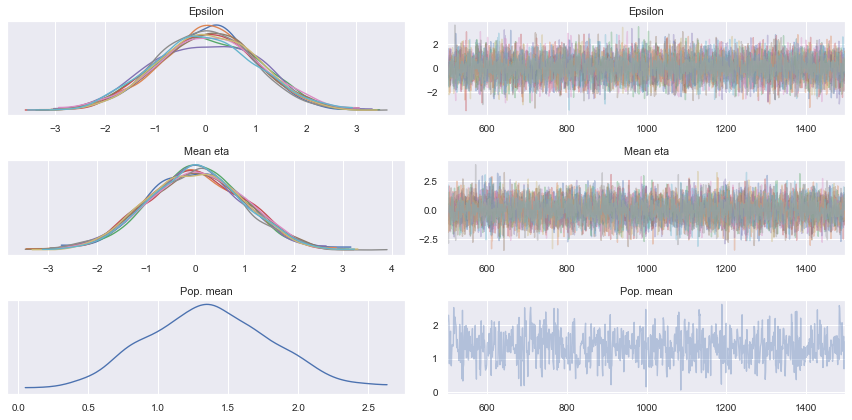

In [19]:
n_samples = 10
log_likelihood = GaussianFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_filter_10_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_filter_10_posterior_samples.sel(draw=slice(warmup, n_iterations)))
plt.tight_layout()

100 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     5      0.25     1        0:00.0
1     6      0.25     1        0:00.0
2     7      0.25     1        0:00.0
3     8      0.25     1        0:00.0
20    2352   0.746    131      0:02.4
40    4521   0.762989 104      0:04.5
60    6552   0.753    97       0:06.6
80    8399   0.755199 88       0:08.4
100   9839   0.75     69       0:09.9
120   10424  0.74     28       0:10.5
140   10932  0.752    25       0:11.0
160   11446  0.738    25       0:11.5
180   11982  0.762    26       0:12.1
200   12530  0.735    27       0:12.6
220   12945  0.771    20       0:13.0
240   13357  0.761    20       0:13.5
260   13721  0.704    18       0:13.8
280   14218  0.757    24       0:14.3
300   14798  0.761    28       0:14.9
320   15250  0.748    22       0:15.3
340   15614  0.744    18       0:15.8
360   16042  0.767689 21       0:16.2
380   16454  0.763    20       0:16.6
400   16850  0.752

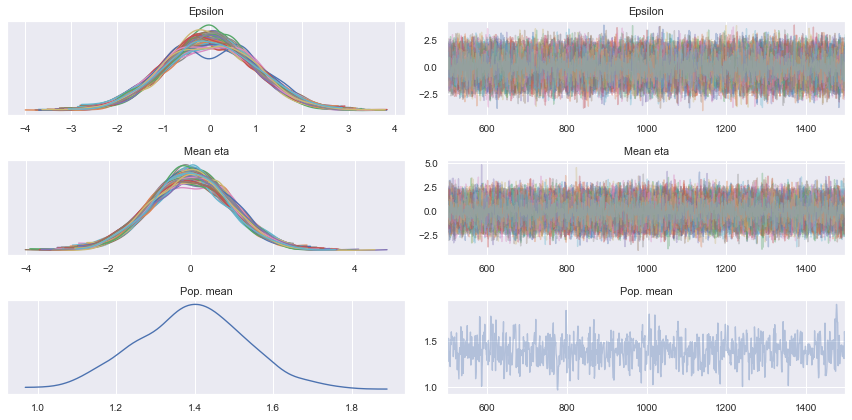

In [20]:
n_samples = 100
log_likelihood = GaussianFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_filter_100_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_filter_100_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

1000 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     5      0.25     1        0:00.1
1     6      0.25     1        0:00.1
2     7      0.25     1        0:00.1
3     8      0.25     1        0:00.1
20    1696   0.762    94       0:12.0
40    4126   0.748    116      0:28.9
60    5854   0.769    83       0:41.1
80    7705   0.747    89       0:54.6
100   9321   0.757    77       1:05.5
120   9773   0.702945 22       1:08.6
140   10297  0.757    25       1:12.1
160   10699  0.72     20       1:14.9
180   11095  0.745    19       1:17.6
200   11579  0.759    24       1:20.8
220   12039  0.773    22       1:23.9
240   12451  0.758    20       1:26.7
260   12769  0.696    16       1:28.9
280   13237  0.758    23       1:32.4
300   13649  0.755    20       1:35.4
320   14061  0.743    20       1:38.1
340   14377  0.772    16       1:40.2
360   14757  0.753    19       1:42.7
380   15121  0.739    18       1:45.3
400   15549  0.767

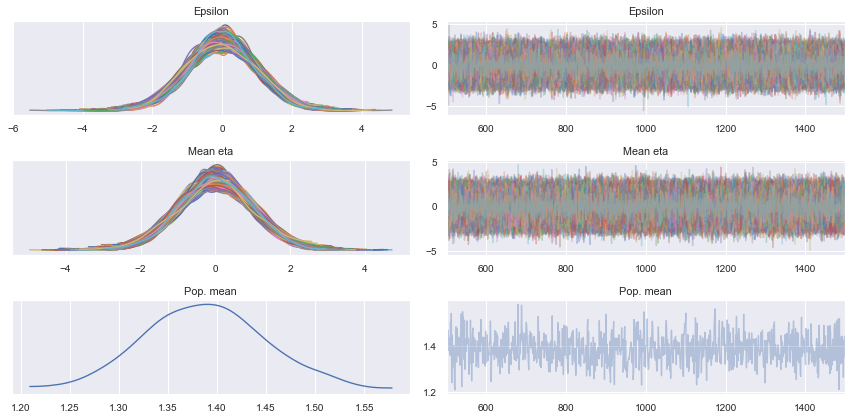

In [21]:
n_samples = 1000
log_likelihood = GaussianFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_filter_1000_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_filter_1000_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

10000 samples

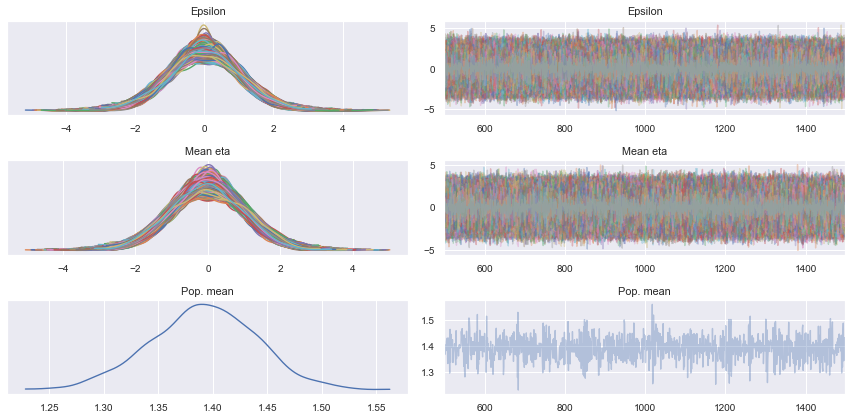

In [62]:
n_samples = 10000
log_likelihood = GaussianFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_filter_10000_posterior_samples = controller.run(
    n_iterations=n_iterations)

warmup=500
az.plot_trace(
    gaussian_filter_10000_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

In [63]:
gaussian_filter_10000_posterior_samples.to_netcdf(
    'derived_data/posteriors/'
    'hierarchical_gaussian_model_gaussian_filter_10000.nc')

In [22]:
gaussian_filter_10000_posterior_samples = xr.load_dataset(
    'derived_data/posteriors/'
    'hierarchical_gaussian_model_gaussian_filter_10000.nc')

### 3. Gaussian KDE filter likelihood

10 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     6      0.25     1        0:00.0
1     7      0.25     1        0:00.0
2     8      0.25     1        0:00.0
3     9      0.25     1        0:00.0
20    2492   0.751    138      0:02.1
40    5011   0.761    120      0:04.3
60    6941   0.741    92       0:05.9
80    8866   0.755    92       0:07.4
100   10467  0.744    77       0:08.7
120   11834  0.731    66       0:09.8
140   14104  0.743    109      0:11.7
160   15597  0.716    71       0:13.0
180   16929  0.764    64       0:14.1
200   18413  0.725    71       0:15.4
220   20024  0.767    77       0:16.7
240   21311  0.766    62       0:17.7
260   22361  0.700287 50       0:18.6
280   23854  0.766    72       0:19.7
300   25310  0.749    70       0:20.9
320   26354  0.745    50       0:21.7
340   27438  0.764    52       0:22.6
360   28384  0.761    46       0:23.3
380   29473  0.762    52       0:24.2
400   30611  0.753

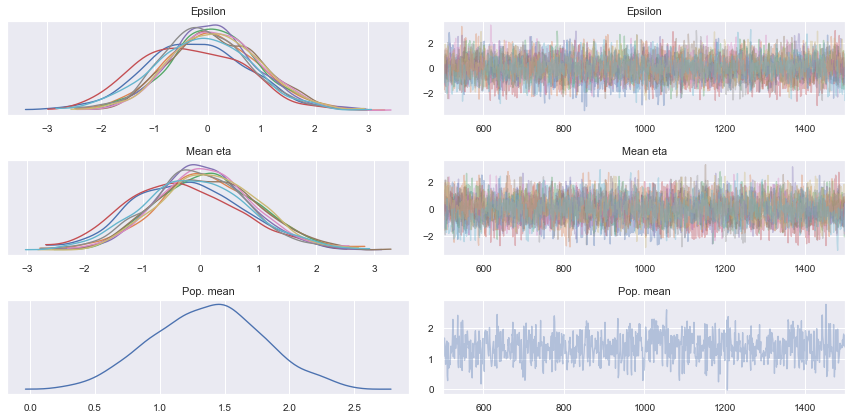

In [8]:
n_samples = 10
log_likelihood = GaussianKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_kde_filter_10_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_kde_filter_10_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

100 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     5      0.25     1        0:00.0
1     6      0.25     1        0:00.1
2     7      0.25     1        0:00.1
3     9      0.167    1        0:00.1
20    1731   0.787    96       0:07.1
40    4107   0.738    114      0:15.5
60    6038   0.769    92       0:22.9
80    7579   0.75     74       0:28.8
100   9193   0.766    77       0:34.6
120   9916   0.709    35       0:37.3
140   10696  0.751    38       0:40.2
160   11547  0.722    41       0:43.6
180   12399  0.743    41       0:47.2
200   13243  0.758    41       0:50.9
220   13959  0.74     35       0:53.2
240   14739  0.768    38       0:56.6
260   15430  0.718    33       0:59.6
280   16274  0.776    41       1:03.1
300   16926  0.759    32       1:05.3
320   17578  0.746    32       1:07.5
340   18150  0.768    28       1:09.5
360   18642  0.752    24       1:11.2
380   19166  0.741    25       1:13.0
400   19706  0.779

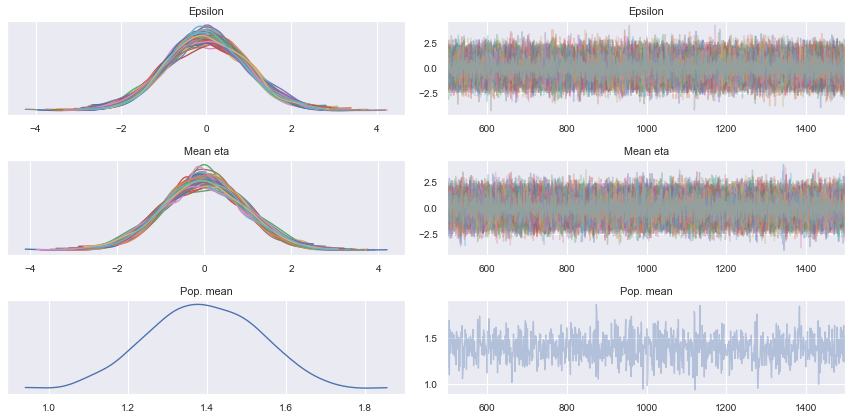

In [10]:
n_samples = 100
log_likelihood = GaussianKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_kde_filter_100_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_kde_filter_100_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

1000 samples

/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:258: RuntimeWarning: overflow encountered in exp
  alpha_dash = min(1.0, np.exp(comparison))
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:157: RuntimeWarning: overflow encountered in exp
  p = min(1, np.exp(other_state.n - self.n))


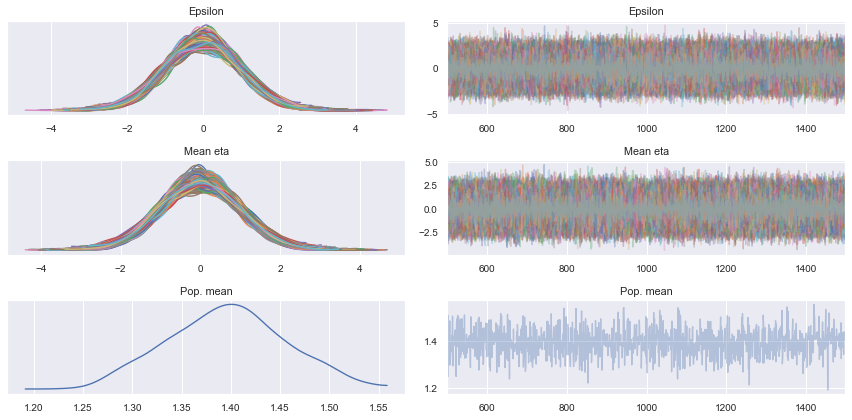

In [11]:
n_samples = 1000
log_likelihood = GaussianKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_kde_filter_1000_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=False)

warmup=500
az.plot_trace(
    gaussian_kde_filter_1000_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

In [13]:
gaussian_kde_filter_1000_posterior_samples.to_netcdf(
    'derived_data/posteriors/'
    'hierarchical_gaussian_model_gaussian_kde_filter_1000.nc')

### 4. Rank matching Gaussian KDE filter likelihood

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     4      0.25     1        0:00.0
1     5      0.25     1        0:00.0
2     6      0.25     1        0:00.0
3     13     0.5      4        0:00.0
20    688    0.735    38       0:00.2


/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:258: RuntimeWarning: overflow encountered in exp
  alpha_dash = min(1.0, np.exp(comparison))
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:157: RuntimeWarning: overflow encountered in exp
  p = min(1, np.exp(other_state.n - self.n))


40    1212   0.759    25       0:00.3
60    1516   0.755    15       0:00.4
80    1826   0.753    15       0:00.5
100   2245   0.734    20       0:00.6
120   2637   0.7406   19       0:00.7
140   2909   0.748783 13       0:00.7
160   3278   0.7      18       0:00.8
180   3772   0.782    24       0:00.9
200   4226   0.735    22       0:01.0
220   4562   0.776    16       0:01.1
240   4916   0.757    17       0:01.1
260   5353   0.713    21       0:01.2
280   5753   0.761    20       0:01.3
300   6137   0.72936  19       0:01.4
320   6507   0.772    18       0:01.5
340   6783   0.75     14       0:01.5
360   7081   0.76     15       0:01.6
380   7373   0.74     14       0:01.6
400   7661   0.776    14       0:01.7
420   7925   0.762    13       0:01.8
440   8171   0.756    12       0:01.8
460   8415   0.728    12       0:01.9
480   8675   0.758    13       0:01.9
500   9141   0.75     23       0:02.0
520   9665   0.815    25       0:02.1
540   10109  0.865    22       0:02.2
560   10597 

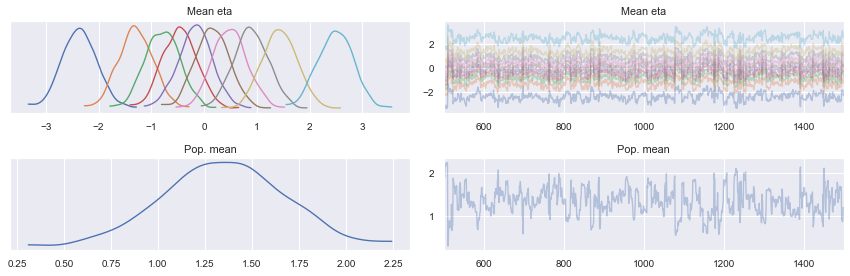

In [139]:
n_samples = 10
log_likelihood = RankMatchingGaussianKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
# log_prior = pints.ComposedLogPrior(*[
#     pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
#     pints.GaussianLogPrior(mean=0, sd=4)])
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
rmg_kde_filter_10_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    rmg_kde_filter_10_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

100 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     7      0.2      2        0:00.0
1     8      0.25     1        0:00.0
2     9      0.25     1        0:00.0
3     16     0.5      4        0:00.0


/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:258: RuntimeWarning: overflow encountered in exp
  alpha_dash = min(1.0, np.exp(comparison))
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:157: RuntimeWarning: overflow encountered in exp
  p = min(1, np.exp(other_state.n - self.n))


20    551    0.761    30       0:00.4
40    1479   0.739    45       0:00.9
60    2092   0.752    30       0:01.2
80    2749   0.773    32       0:01.6
100   3383   0.742    31       0:01.9
120   3724   0.713    17       0:02.1
140   4024   0.768    15       0:02.3
160   4347   0.7      16       0:02.5
180   4783   0.753    21       0:02.7
200   5134   0.77     17       0:02.9
220   5413   0.759    14       0:03.1
240   5733   0.749    16       0:03.2
260   5953   0.73     11       0:03.3
280   6225   0.763    13       0:03.5
300   6445   0.739    11       0:03.6
320   6685   0.767    12       0:03.7
340   6897   0.759    11       0:03.9
360   7125   0.764    11       0:04.0
380   7337   0.749    11       0:04.1
400   7517   0.769    9        0:04.2
420   7760   0.734    12       0:04.3
440   7964   0.773    10       0:04.4
460   8201   0.714    12       0:04.6
480   8498   0.766531 15       0:04.7
500   8806   0.754    15       0:04.9
520   9106   0.841    15       0:05.1
540   9406  

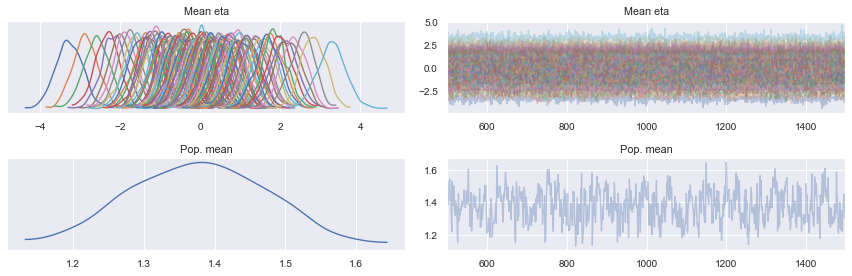

In [140]:
n_samples = 100
log_likelihood = RankMatchingGaussianKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
rmg_kde_filter_100_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    rmg_kde_filter_100_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

1000 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     5      0.25     1        0:00.0
1     6      0.25     1        0:00.0
2     7      0.25     1        0:00.0
3     8      0.25     1        0:00.1


/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:258: RuntimeWarning: overflow encountered in exp
  alpha_dash = min(1.0, np.exp(comparison))
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:157: RuntimeWarning: overflow encountered in exp
  p = min(1, np.exp(other_state.n - self.n))


20    1423   0.758    79       0:05.4
40    3208   0.753    85       0:13.0
60    5308   0.727    100      0:20.9
80    7032   0.782    83       0:28.8
100   8599   0.759    75       0:35.1
120   8963   0.708    18       0:36.7
140   9383   0.753    20       0:38.6
160   9685   0.732404 15       0:39.9
180   10065  0.762    19       0:41.9
200   10405  0.754    17       0:43.2
220   10761  0.748    17       0:44.6
240   11061  0.769    15       0:45.8
260   11353  0.714    14       0:46.9
280   11733  0.76     19       0:48.9
300   12033  0.752    15       0:50.0
320   12453  0.749    20       0:51.6
340   12833  0.751    19       0:53.1
360   13133  0.771    15       0:54.3
380   13513  0.76     19       0:55.7
400   13829  0.752    16       0:57.5
420   14129  0.742    15       0:58.7
440   14461  0.755    16       0:59.9
460   14743  0.713    14       1:01.1
480   15187  0.772    22       1:03.7
500   15527  0.753    17       1:04.9
520   15827  0.804    15       1:06.0
540   16127 

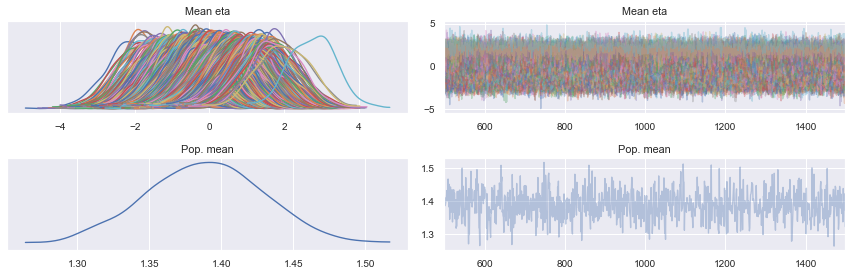

In [145]:
n_samples = 1000
log_likelihood = RankMatchingGaussianKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
rmg_kde_filter_1000_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    rmg_kde_filter_1000_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

### 5. Anchor KDE likelihood

10 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     7      0.25     2        0:00.1
1     8      0.25     1        0:00.1
2     9      0.25     1        0:00.1
3     12     0.125    2        0:00.1
20    2713   0.765    151      0:03.7
40    4519   0.749    86       0:05.7
60    6520   0.758    96       0:07.7
80    8132   0.766    77       0:09.2
100   9917   0.76     85       0:11.4
120   11546  0.715    78       0:13.4
140   13414  0.77     89       0:15.1
160   14573  0.709    55       0:16.2
180   16169  0.763    76       0:17.6
200   17478  0.771    63       0:18.8
220   19245  0.725276 85       0:21.6
240   20573  0.785    64       0:22.8
260   21542  0.704    46       0:23.7
280   22917  0.762    66       0:25.0
300   24529  0.743    77       0:26.8
320   25693  0.76     56       0:28.7
340   26899  0.759    58       0:29.8
360   28092  0.761    57       0:30.9
380   29395  0.745    63       0:32.1
400   30442  0.748

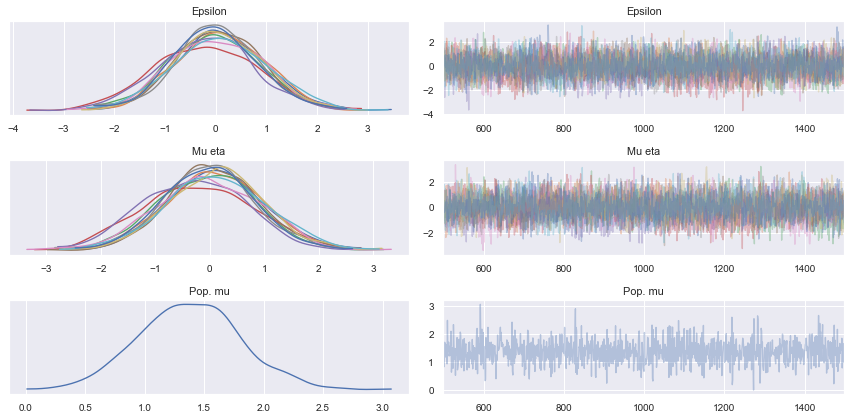

In [351]:
n_samples = 11
n_anchors = 10
log_likelihood = AnchorKDELogLikelihood(
    observations=data, n_samples=n_samples, n_anchors=n_anchors)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
anchor_kde_10_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    anchor_kde_10_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

100 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     5      0.25     1        0:00.0
1     6      0.25     1        0:00.1
2     7      0.25     1        0:00.1
3     8      0.25     1        0:00.1
20    2210   0.761    123      0:10.6
40    4581   0.752    113      0:20.4
60    6122   0.736    74       0:26.9
80    7964   0.785465 88       0:34.6
100   10024  0.727    98       0:44.5
120   11085  0.736    51       0:49.0
140   11961  0.732    42       0:52.6
160   12817  0.734688 41       0:56.2
180   13581  0.744    37       1:00.3
200   14233  0.762152 32       1:02.9
220   14853  0.745552 30       1:05.3
240   15441  0.768    28       1:07.6
260   15990  0.731    26       1:10.7
280   16850  0.737    41       1:14.2
300   17550  0.758    34       1:16.9
320   18282  0.773    35       1:19.7
340   18950  0.744    32       1:23.4
360   19522  0.776    28       1:25.7
380   20142  0.748    30       1:28.1
400   20810  0.748

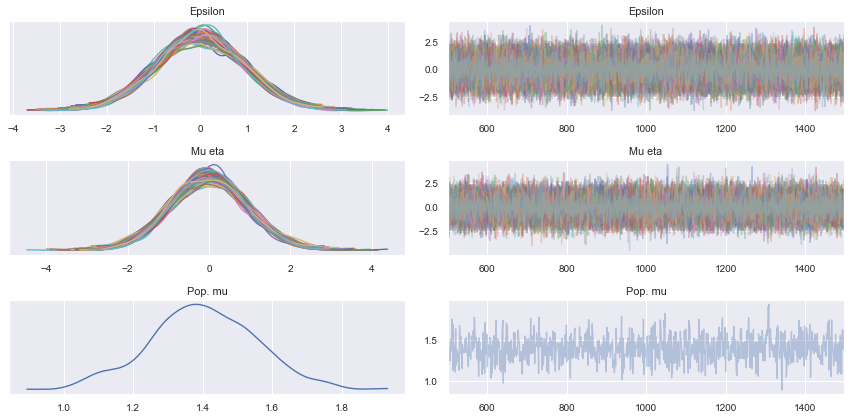

In [353]:
n_samples = 100
n_anchors = 99
log_likelihood = AnchorKDELogLikelihood(
    observations=data, n_samples=n_samples, n_anchors=n_anchors)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
anchor_kde_100_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    anchor_kde_100_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

1000 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     5      0.25     1        0:00.1
1     6      0.25     1        0:00.1
2     7      0.25     1        0:00.1
3     8      0.25     1        0:00.2
20    1872   0.759    104      0:29.6
40    3852   0.741    95       1:03.2
60    6155   0.762    110      1:39.6
80    7943   0.74     86       2:09.1
100   9827   0.789    90       2:36.6
120   11028  0.721    58       2:54.3
140   12256  0.752    59       3:13.9
160   13091  0.723    40       3:26.3
180   14143  0.763    51       3:42.0
200   15099  0.755    46       3:56.1
220   16023  0.743    44       4:10.8
240   16835  0.757882 39       4:22.7
260   17515  0.716    33       4:32.7
280   18455  0.754    45       4:46.6
300   19331  0.743    42       5:00.6
320   20127  0.758    38       5:12.5
340   20859  0.738    35       5:23.3
360   21687  0.759    40       5:36.6
380   22435  0.768    36       5:47.8
400   23167  0.766

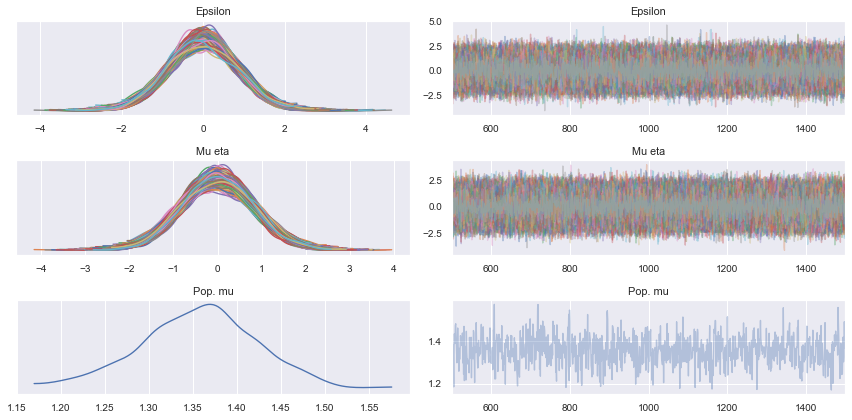

In [354]:
n_samples = 1000
n_anchors = 100
log_likelihood = AnchorKDELogLikelihood(
    observations=data, n_samples=n_samples, n_anchors=n_anchors)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
anchor_kde_1000_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    anchor_kde_1000_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

### 6. Gaussian data likelihood

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     10     0.125    2        0:00.0
1     11     0.25     1        0:00.0
2     13     0.167    1        0:00.0
3     28     0.5      8        0:00.0
20    179    0.758    9        0:00.1
40    359    0.758    9        0:00.1
60    515    0.766    8        0:00.2
80    687    0.731    9        0:00.2
100   877    0.756    9        0:00.3
120   1075   0.724    10       0:00.4
140   1243   0.752    8        0:00.4
160   1419   0.717    9        0:00.4
180   1599   0.754    9        0:00.5
200   1771   0.766    9        0:00.5
220   1935   0.763    8        0:00.6
240   2081   0.741    7        0:00.6
260   2221   0.744    7        0:00.6
280   2413   0.759    10       0:00.7
300   2553   0.753    7        0:00.7
320   2717   0.752956 8        0:00.8
340   2877   0.773    8        0:00.8
360   3001   0.748    6        0:00.9
380   3125   0.763    6        0:00.9
400   3257   0.746

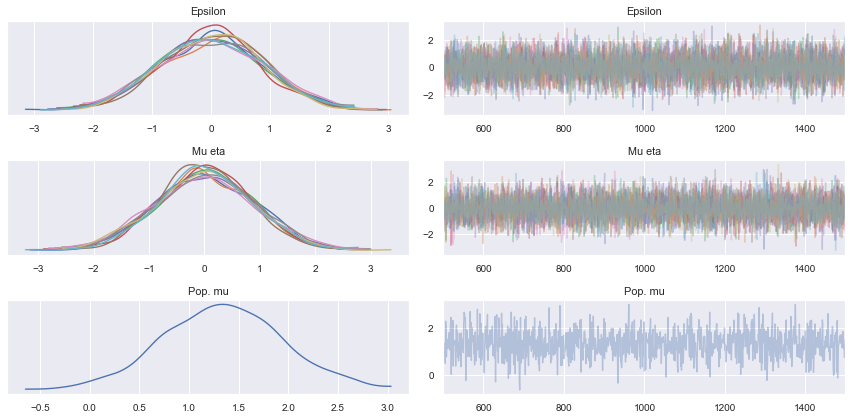

In [339]:
n_samples = 10
log_likelihood = GaussianDataLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_data_10_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_data_10_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

100 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     7      0.25     1        0:00.0
1     8      0.25     1        0:00.0
2     9      0.25     1        0:00.0
3     10     0.25     1        0:00.0
20    441    0.747    24       0:00.5
40    924    0.759    23       0:01.0
60    1371   0.752    22       0:01.4
80    1899   0.752    26       0:02.0
100   2409   0.754    25       0:02.5
120   2669   0.719797 13       0:02.7
140   2961   0.74     14       0:03.0
160   3285   0.731    16       0:03.3
180   3577   0.739799 14       0:03.6
200   3845   0.765    13       0:03.8
220   4113   0.752    13       0:04.1
240   4357   0.756    12       0:04.3
260   4690   0.727    16       0:04.7
280   4974   0.768    14       0:04.9
300   5258   0.755    14       0:05.2
320   5518   0.773    13       0:05.5
340   5778   0.745    13       0:05.7
360   6022   0.758    12       0:06.0
380   6258   0.758    12       0:06.2
400   6502   0.744

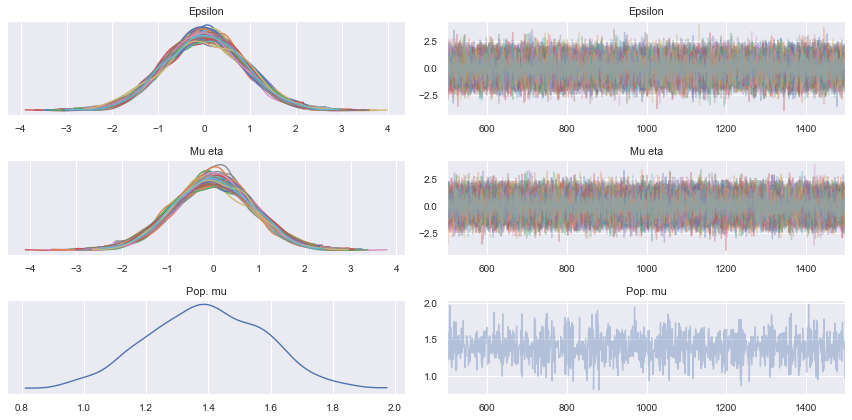

In [340]:
n_samples = 100
log_likelihood = GaussianDataLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_data_100_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_data_100_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

1000 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     5      0.25     1        0:00.1
1     6      0.25     1        0:00.1
2     7      0.25     1        0:00.1
3     8      0.25     1        0:00.1


/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:258: RuntimeWarning: overflow encountered in exp
  alpha_dash = min(1.0, np.exp(comparison))


20    2115   0.767    118      0:15.8
40    3847   0.755    83       0:29.2
60    5523   0.739    80       0:41.8
80    7063   0.743    74       0:54.5
100   8668   0.77     77       1:06.5
120   9248   0.712    28       1:11.6
140   9788   0.755    26       1:15.9
160   10167  0.726    18       1:18.7
180   10779  0.737013 30       1:24.7
200   11303  0.765    25       1:28.4
220   11723  0.746    20       1:31.4
240   12199  0.75     23       1:35.0
260   12681  0.716    23       1:39.3
280   13165  0.745    24       1:43.3
300   13641  0.758    23       1:46.9
320   14133  0.748    24       1:50.4
340   14529  0.76     19       1:54.0
360   14941  0.761    20       1:56.9
380   15353  0.745    20       1:59.8
400   15845  0.767    24       2:03.3
420   16241  0.736    19       2:06.9
440   16637  0.778705 19       2:09.8
460   17064  0.713    21       2:12.8
480   17564  0.776    24       2:16.4
500   17984  0.744    20       2:20.1
520   18284  0.811    15       2:22.2
540   18584 

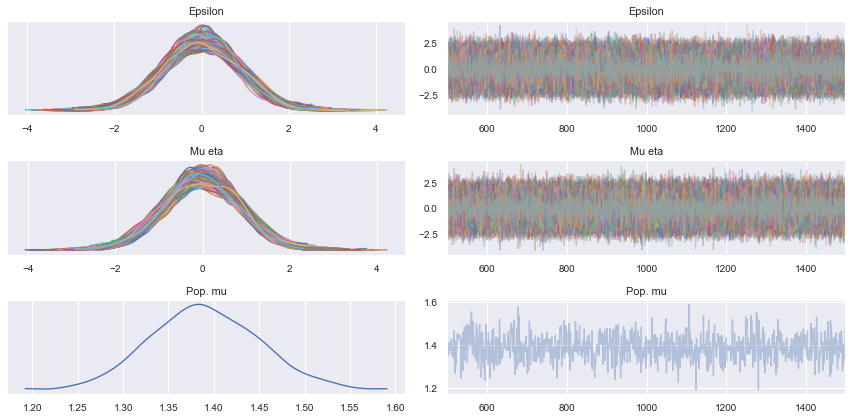

In [341]:
n_samples = 1000
log_likelihood = GaussianDataLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_data_1000_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_data_1000_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

## Comparison to analytic posterior

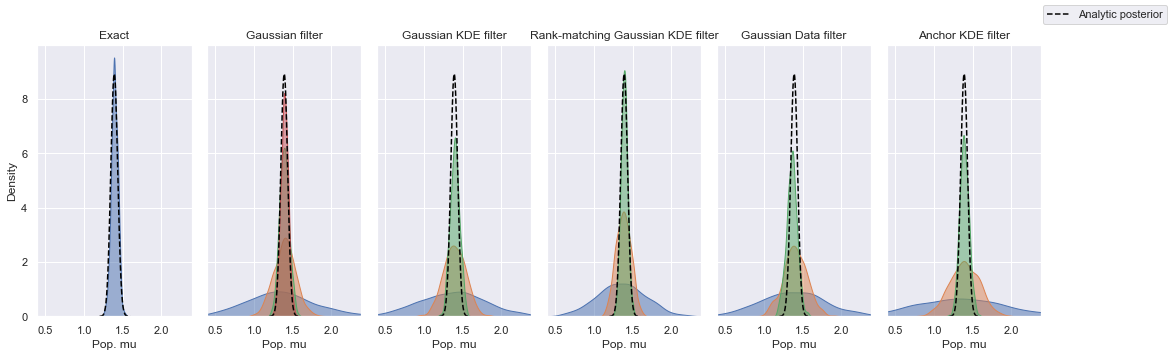

In [355]:
# Get true distribution
n = len(data)
posterior_var = 16 / (1 + n * 8)
posterior_mean = posterior_var * n * np.mean(data) / 2
mus = np.linspace(1.2, 1.6, num=200)
true_pdf = scipy.stats.norm(posterior_mean, np.sqrt(posterior_var)).pdf(mus)

# Create figure
fig, axes = plt.subplots(
    1, 6, figsize=(18, 5), sharey='row', sharex='row')
plt.subplots_adjust(wspace=0.1, hspace=0.3)
axes[0].set_xlim([posterior_mean - 1, posterior_mean + 1])
axes[0].set_xlabel('Pop. mu')
axes[1].set_xlabel('Pop. mu')
axes[2].set_xlabel('Pop. mu')
axes[3].set_xlabel('Pop. mu')
axes[4].set_xlabel('Pop. mu')
axes[5].set_xlabel('Pop. mu')
axes[0].set_title('Exact')
axes[1].set_title('Gaussian filter')
axes[2].set_title('Gaussian KDE filter')
axes[3].set_title('Rank-matching Gaussian KDE filter')
axes[4].set_title('Gaussian Data filter')
axes[5].set_title('Anchor KDE filter')
colors = sns.color_palette()

# Plot exact likelihood inference
warmup = 500
thinning = 1
mu_samples = exact_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[0],
    palette=colors[0], legend=False)

# Plot Gaussian filter posteriors
warmup = 1000
thinning = 1
mu_samples = gaussian_filter_10_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[1],
    palette=colors[0], legend=False)

warmup = 500
thinning = 1
mu_samples = gaussian_filter_100_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[1],
    palette=colors[1], legend=False)

warmup = 500
thinning = 1
mu_samples = gaussian_filter_1000_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[1],
    palette=colors[2], legend=False)

warmup = 500
thinning = 1
mu_samples = gaussian_filter_10000_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[1],
    palette=colors[3], legend=False)

# Plot KDE filter posteriors
warmup = 500
thinning = 1
mu_samples = gaussian_kde_filter_10_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[2],
    palette=colors[0], legend=False)

warmup = 500
thinning = 1
mu_samples = gaussian_kde_filter_100_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[2],
    palette=colors[1], legend=False)

warmup = 500
thinning = 1
mu_samples = gaussian_kde_filter_1000_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[2],
    palette=colors[1], legend=False)

# Plot RMG KDE filter posteriors
warmup = 500
thinning = 1
mu_samples = rmg_kde_filter_10_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[3],
    palette=colors[0], legend=False)

warmup = 500
thinning = 1
mu_samples = rmg_kde_filter_100_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[3],
    palette=colors[1], legend=False)

warmup = 500
thinning = 1
mu_samples = rmg_kde_filter_1000_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[3],
    palette=colors[1], legend=False)

# Plot Anchor KDE posteriors
warmup = 500
thinning = 1
mu_samples = anchor_kde_10_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mu'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[4],
    palette=colors[0], legend=False)

warmup = 500
thinning = 1
mu_samples = anchor_kde_100_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mu'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[4],
    palette=colors[1], legend=False)

warmup = 500
thinning = 1
mu_samples = anchor_kde_1000_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mu'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[4],
    palette=colors[1], legend=False)

# Plot Gaussian data posteriors
warmup = 500
thinning = 1
mu_samples = gaussian_data_10_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mu'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[5],
    palette=colors[0], legend=False)

warmup = 500
thinning = 1
mu_samples = gaussian_data_100_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mu'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[5],
    palette=colors[1], legend=False)

warmup = 500
thinning = 1
mu_samples = gaussian_data_1000_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mu'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[5],
    palette=colors[1], legend=False)

# Overlay exact posterior
axes[0].plot(
    mus, true_pdf, color='black', linestyle='--', label='Analytic posterior')
axes[1].plot(
    mus, true_pdf, color='black', linestyle='--')
axes[2].plot(
    mus, true_pdf, color='black', linestyle='--')
axes[3].plot(
    mus, true_pdf, color='black', linestyle='--')
axes[4].plot(
    mus, true_pdf, color='black', linestyle='--')
axes[5].plot(
    mus, true_pdf, color='black', linestyle='--')

fig.legend()
plt.show()

## Visualise filter approximations of data

### 1. Gaussian approximation of data

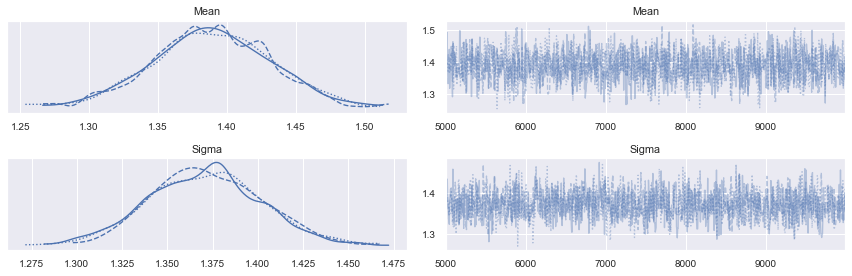

In [148]:
class GaussianLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations):
        self._observations = observations.flatten()

    def __call__(self, parameters):
        # Compute population contribution
        mean, sigma = parameters
        score = np.sum(
            scipy.stats.norm(loc=mean, scale=sigma).logpdf(
                self._observations))

        return score

    def n_parameters(self):
        return 2

    def get_parameter_names(self):
        return ['Mean', 'Sigma']

    def get_id(self):
        return [None, None]


log_likelihood = GaussianLogLikelihood(observations=data)
log_prior = pints.ComposedLogPrior(*[
    pints.UniformLogPrior(-10, 10000),
    pints.UniformLogPrior(0, 1000)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(3)
controller.set_parallel_evaluation(True)
controller.set_transform(pints.LogTransformation(log_posterior.n_parameters()))
n_iterations = 10000
gaussian_posterior = controller.run(
    n_iterations=n_iterations, log_to_screen=False)

warmup = 5000
thinning_ratio = 5
az.plot_trace(
    gaussian_posterior.sel(
        draw=slice(warmup, n_iterations, thinning_ratio)))
plt.tight_layout()

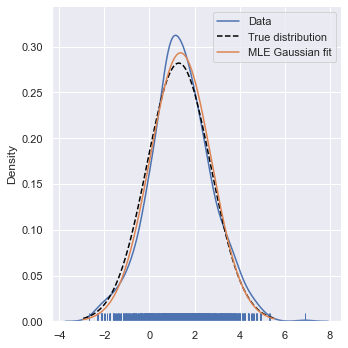

In [203]:
# Sample from Gaussian approximation
mean = true_parameters[0]
sigma = np.sqrt(true_parameters[1]**2 + true_parameters[2]**2)
mus = np.linspace(mean - 3 * sigma, mean + 3 * sigma, num=200)
true_pdf = scipy.stats.norm(mean, sigma).pdf(mus)

# Sample from Gaussian approximation
mean = 1.38
sigma = 1.36
approx_pdf = scipy.stats.norm(mean, sigma).pdf(mus)

# Visualse approximation and data
ax = sns.displot(data.flatten(), kind='kde', rug=True, label='Data')
plt.plot(mus, true_pdf, color='black', linestyle='dashed', label='True distribution')
plt.plot(mus, approx_pdf, color=colors[1], label='MLE Gaussian fit')

plt.legend()
plt.show()

### 2. Gaussian KDE approximation of data

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     7      0.125    2        0:00.0
1     8      0.25     1        0:00.0
2     9      0.25     1        0:00.0
3     10     0.5      1        0:00.0
20    283    0.752    16       0:00.4
40    594    0.759    15       0:00.8
60    1026   0.769283 21       0:01.2
80    1354   0.741    16       0:01.6
100   1801   0.787    22       0:02.0
120   2508   0.717    34       0:02.8
140   3189   0.759886 33       0:03.5
160   3653   0.736    22       0:04.0
180   4295   0.731    31       0:04.6
200   4787   0.781    24       0:05.1
220   5229   0.746    22       0:05.6
240   5697   0.746    23       0:06.1
260   6309   0.76     29       0:06.7
280   6730   0.741    21       0:07.1
300   7646   0.765    44       0:08.0
320   8252   0.753795 29       0:08.6
340   8734   0.758    23       0:09.1
360   9190   0.782    22       0:09.6
380   9778   0.752    28       0:10.2
400   10314  0.763

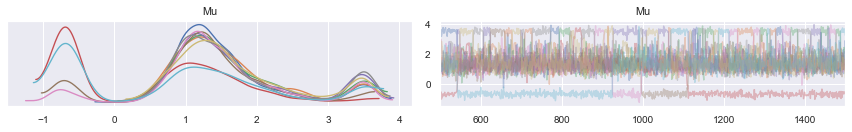

In [195]:
class GaussianKDELogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, n_samples=1000, kernel_scale=None):
        self._observations = observations.flatten()
        self._n_samples = int(n_samples)
        self._normal = chi.GaussianErrorModel()

        # Set kernel scale
        # (If None or non-positive use Scott's rule of thumb (like scipy))
        if (not kernel_scale) or (kernel_scale <=0):
            kernel_scale = \
                np.std(observations, ddof=1) \
                * (4 / 3 / self._n_samples) ** (0.2)
        self._kernel_scale = kernel_scale

    def __call__(self, parameters):
        mu = np.array(parameters[:self._n_samples])

        score = np.sum(scipy.special.logsumexp(
            - np.log(2 * np.pi) / 2 - np.log(self._kernel_scale) - (
                mu[np.newaxis, :] -
                self._observations[:, np.newaxis])**2 \
            / self._kernel_scale**2 / 2, axis=1) - np.log(self._n_samples))

        return score

    def evaluateS1(self, parameters):
        mu = np.array(parameters[:self._n_samples])

        # Estimate log-likelihood as the mean across kdes
        scores = \
            - np.log(2 * np.pi) / 2 - np.log(self._kernel_scale) - (
                mu[np.newaxis, :] -
                self._observations[:, np.newaxis])**2 \
            / self._kernel_scale**2 / 2
        score = np.sum(
            scipy.special.logsumexp(scores, axis=1) - np.log(self._n_samples))

        # Collect sensitivities
        log_softmax = \
            scores - np.max(scores, axis=1)[:, np.newaxis] \
            - scipy.special.logsumexp(
            scores - np.max(scores, axis=1)[:, np.newaxis], axis=1
            )[:, np.newaxis]

        sensitivities = np.zeros(shape=self.n_parameters())
        sensitivities[:self._n_samples] = \
            - 1 / self._kernel_scale**2 * np.sum(
            np.sign(mu[np.newaxis, :] -
            self._observations[:, np.newaxis])
            * np.exp(
            np.log(np.abs(mu[np.newaxis, :] -
            self._observations[:, np.newaxis])) +
            log_softmax),
            axis=0)

        return score, sensitivities

    def n_parameters(self):
        return self._n_samples

    def get_parameter_names(self):
        return ['Mu'] * self._n_samples

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_samples)]


n_samples = 10
log_likelihood = GaussianKDELogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.UniformLogPrior(-10, 10)] * n_samples)
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_kde_10_posterior = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup = 500
thinning_ratio = 1
az.plot_trace(
    gaussian_kde_10_posterior.sel(
        draw=slice(warmup, n_iterations, thinning_ratio)))
plt.tight_layout()

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     8      0.417    3        0:00.1
1     9      0.25     1        0:00.1
2     10     0.25     1        0:00.1
3     11     0.25     1        0:00.1
20    188    0.757    10       0:01.0
40    320    0.768    7        0:01.6
60    457    0.763    7        0:02.2
80    563    0.732    6        0:02.7
100   649    0.719133 4        0:03.1
120   757    0.72     6        0:03.6
140   871    0.75     6        0:04.1
160   1006   0.721    7        0:04.7
180   1126   0.74     6        0:05.3
200   1240   0.747048 6        0:05.8
220   1369   0.762    7        0:06.4
240   1440   0.667    4        0:06.7
260   2469   0.757    49       0:12.2
280   2591   0.747    6        0:12.8
300   2734   0.766    7        0:13.5
320   2935   0.768    10       0:14.4
340   3084   0.756    8        0:15.1
360   3192   0.696    6        0:15.6
380   3677   0.831    24       0:17.9
400   3836   0.768

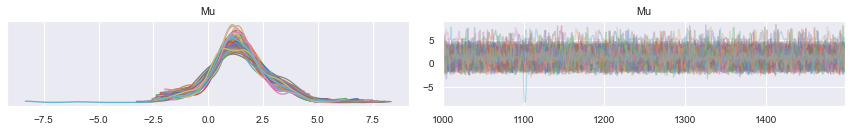

In [197]:
n_samples = 100
log_likelihood = GaussianKDELogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.UniformLogPrior(-10, 10)] * n_samples)
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_kde_100_posterior = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup = 1000
thinning_ratio = 1
az.plot_trace(
    gaussian_kde_100_posterior.sel(
        draw=slice(warmup, n_iterations, thinning_ratio)))
plt.tight_layout()

In [ ]:
n_samples = 1000
log_likelihood = GaussianKDELogLikelihood(
    observations=data, n_samples=n_samples,
    kernel_scale=np.std(data, ddof=1)/10)
log_prior = pints.ComposedLogPrior(*[
    pints.UniformLogPrior(-100, 100)] * n_samples)
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
controller._initial_params[0, 0] = means
n_iterations = 1500
gaussian_kde_1000_posterior = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup = 500
thinning_ratio = 1
az.plot_trace(
    gaussian_kde_1000_posterior.sel(
        draw=slice(warmup, n_iterations, thinning_ratio)))
plt.tight_layout()

Has diverging iterations all over the place!

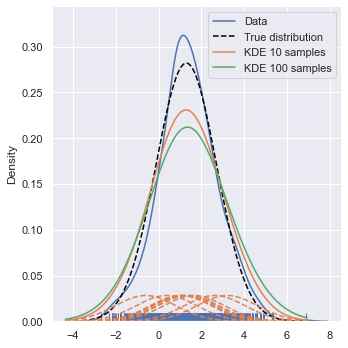

In [207]:
# Sample from Gaussian approximation
mean = true_parameters[0]
sigma = np.sqrt(true_parameters[1]**2 + true_parameters[2]**2)
mus = np.linspace(mean - 4 * sigma, mean + 4 * sigma, num=200)
true_pdf = scipy.stats.norm(mean, sigma).pdf(mus)

# Construct KDE fit
mu_samples = gaussian_kde_10_posterior.Mu.values[0, -1]
pdf_10_samples = np.empty(shape=(len(mu_samples), len(mus)))
kernel_size = np.std(data, ddof=1) * (4 / 3 / len(mu_samples)) ** (0.2)
for ids, mu in enumerate(mu_samples):
    pdf_10_samples[ids] = scipy.stats.norm(mu, sigma).pdf(mus)
indiv_pdf_10_samples = pdf_10_samples
pdf_10_samples = np.mean(pdf_10_samples, axis=0)

mu_samples = gaussian_kde_100_posterior.Mu.values[0, -1]
pdf_100_samples = np.empty(shape=(len(mu_samples), len(mus)))
kernel_size = np.std(data, ddof=1) * (4 / 3 / len(mu_samples)) ** (0.2)
for ids, mu in enumerate(mu_samples):
    pdf_100_samples[ids] = scipy.stats.norm(mu, sigma).pdf(mus)
pdf_100_samples = np.mean(pdf_100_samples, axis=0)

mu_samples = gaussian_kde_1000_posterior.Mu.values[0, -1]
pdf_1000_samples = np.empty(shape=(len(mu_samples), len(mus)))
kernel_size = np.std(data, ddof=1) * (4 / 3 / len(mu_samples)) ** (0.2)
for ids, mu in enumerate(mu_samples):
    pdf_1000_samples[ids] = scipy.stats.norm(mu, sigma).pdf(mus)
pdf_1000_samples = np.mean(pdf_1000_samples, axis=0)

# Visualse approximation and data
ax = sns.displot(data.flatten(), kind='kde', rug=True, label='Data')
plt.plot(mus, true_pdf, color='black', linestyle='dashed', label='True distribution')
plt.plot(mus, pdf_10_samples, color=colors[1], label='KDE 10 samples')
plt.plot(mus, pdf_100_samples, color=colors[2], label='KDE 100 samples')
for pdf in indiv_pdf_10_samples:
    plt.plot(mus, pdf / 10, color=colors[1], linestyle='dashed')
# plt.plot(mus, pdf_1000_samples, color=colors[3], label='KDE 1000 samples')

plt.legend()
plt.show()

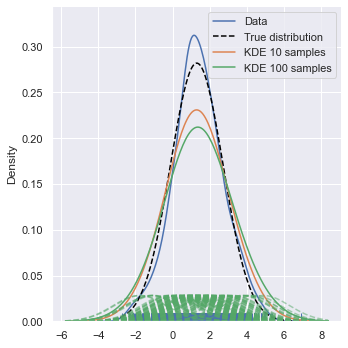

In [210]:
# Sample from Gaussian approximation
mean = true_parameters[0]
sigma = np.sqrt(true_parameters[1]**2 + true_parameters[2]**2)
mus = np.linspace(mean - 5 * sigma, mean + 5 * sigma, num=200)
true_pdf = scipy.stats.norm(mean, sigma).pdf(mus)

# Construct KDE fit
mu_samples = gaussian_kde_10_posterior.Mu.values[0, -1]
pdf_10_samples = np.empty(shape=(len(mu_samples), len(mus)))
kernel_size = np.std(data, ddof=1) * (4 / 3 / len(mu_samples)) ** (0.2)
for ids, mu in enumerate(mu_samples):
    pdf_10_samples[ids] = scipy.stats.norm(mu, sigma).pdf(mus)
pdf_10_samples = np.mean(pdf_10_samples, axis=0)

mu_samples = gaussian_kde_100_posterior.Mu.values[0, -1]
pdf_100_samples = np.empty(shape=(len(mu_samples), len(mus)))
kernel_size = np.std(data, ddof=1) * (4 / 3 / len(mu_samples)) ** (0.2)
for ids, mu in enumerate(mu_samples):
    pdf_100_samples[ids] = scipy.stats.norm(mu, sigma).pdf(mus)
indiv_pdf_100_samples = pdf_100_samples
pdf_100_samples = np.mean(pdf_100_samples, axis=0)

mu_samples = gaussian_kde_1000_posterior.Mu.values[0, -1]
pdf_1000_samples = np.empty(shape=(len(mu_samples), len(mus)))
kernel_size = np.std(data, ddof=1) * (4 / 3 / len(mu_samples)) ** (0.2)
for ids, mu in enumerate(mu_samples):
    pdf_1000_samples[ids] = scipy.stats.norm(mu, sigma).pdf(mus)
pdf_1000_samples = np.mean(pdf_1000_samples, axis=0)

# Visualse approximation and data
ax = sns.displot(data.flatten(), kind='kde', rug=True, label='Data')
plt.plot(mus, true_pdf, color='black', linestyle='dashed', label='True distribution')
plt.plot(mus, pdf_10_samples, color=colors[1], label='KDE 10 samples')
plt.plot(mus, pdf_100_samples, color=colors[2], label='KDE 100 samples')
for pdf in indiv_pdf_100_samples:
    plt.plot(mus, pdf / 10, color=colors[2], linestyle='dashed', alpha=0.5)
# plt.plot(mus, pdf_1000_samples, color=colors[3], label='KDE 1000 samples')

plt.legend()
plt.show()

### Check whether the gradients are reason for diverging iterations

### 3. Rank-matching Gaussian KDE filter 

In [218]:
class RankMatchingGaussianKDELogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, n_samples=1000):
        # Make sure n_obs is a multiple of n_samples
        n_samples = int(n_samples)
        if len(observations) % n_samples != 0:
            raise ValueError(
                'n_samples has to be a divisor of n_observations.')

        # Rank observations and rearrange into blocks of n_obs / n_samples
        n_block = int(len(observations) / n_samples)
        self._observations = np.sort(observations.flatten()).reshape(
            (n_samples, n_block))
        self._n_samples = n_samples

        # Set kernel scale
        # (Each block gets its own kernel)
        kernel_scale = np.zeros(n_samples)
        if len(observations) > n_samples:
            kernel_scale = \
                np.std(self._observations, ddof=1, axis=1) \
                * (4 / 3) ** (0.2)
        self._kernel_scale = kernel_scale[:, np.newaxis]

    def __call__(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        mu = np.array(parameters[:self._n_samples])

        # Estimate log-likelihood as the mean across kdes
        kernel_var = sigma**2 + self._kernel_scale**2
        score = np.sum(
            - np.log(2 * np.pi) / 2 - np.log(kernel_var) / 2 - (
                mu[:, np.newaxis] - self._observations)**2 \
            / kernel_var / 2)

        return score

    def evaluateS1(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        mu = np.array(parameters[:self._n_samples])

        # Estimate log-likelihood as the mean across kdes
        kernel_var = sigma**2 + self._kernel_scale**2
        score = np.sum(
            - np.log(2 * np.pi) / 2 - np.log(kernel_var) / 2 - (
                mu[:, np.newaxis] - self._observations)**2 \
            / kernel_var / 2)

        # Collect sensitivities
        sensitivities = np.zeros(shape=self.n_parameters())
        sensitivities[:self._n_samples] = \
            - np.sum(pop_sigma / kernel_var *
                (mu[:, np.newaxis] - self._observations), axis=1)

        return score, sensitivities

    def n_parameters(self):
        return self._n_samples

    def get_parameter_names(self):
        return ['Mean eta'] * self._n_samples

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_samples)]

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     7      0.25     1        0:00.0
1     8      0.25     1        0:00.0
2     9      0.25     1        0:00.0
3     10     0.25     1        0:00.0
20    64     0.756105 3        0:00.0
40    150    0.758    5        0:00.1
60    232    0.746577 4        0:00.1
80    318    0.742    5        0:00.1
100   402    0.742    4        0:00.1
120   482    0.725    4        0:00.2


/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:258: RuntimeWarning: overflow encountered in exp
  alpha_dash = min(1.0, np.exp(comparison))
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:157: RuntimeWarning: overflow encountered in exp
  p = min(1, np.exp(other_state.n - self.n))


140   582    0.764    5        0:00.2
160   670    0.701    5        0:00.2
180   772    0.752    5        0:00.3
200   862    0.759    5        0:00.3
220   962    0.759    5        0:00.4
240   1056   0.75     5        0:00.4
260   1156   0.717    5        0:00.5
280   1262   0.757    5        0:00.5
300   1366   0.745    5        0:00.5
320   1470   0.774    5        0:00.6
340   1552   0.769    4        0:00.6
360   1628   0.742    4        0:00.6
380   1732   0.766    5        0:00.6
400   1824   0.748629 5        0:00.7
420   1912   0.762    5        0:00.7
440   1988   0.773    4        0:00.7
460   2066   0.732    4        0:00.8
480   2198   0.742944 7        0:00.8
500   2314   0.772    6        0:00.8
520   2434   0.832176 6        0:00.9
540   2558   0.832    6        0:00.9
560   2678   0.854    6        0:00.9
580   2790   0.82     6        0:01.0
600   2894   0.835    5        0:01.0
620   3014   0.85     6        0:01.1
640   3118   0.829    5        0:01.1
660   3238  

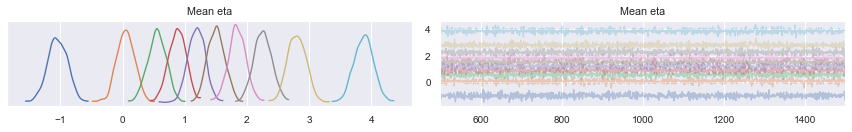

In [219]:
n_samples = 10
log_likelihood = RankMatchingGaussianKDELogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.UniformLogPrior(-10, 10)] * n_samples)
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
rmg_kde_10_posterior = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup = 500
thinning_ratio = 1
az.plot_trace(
    rmg_kde_10_posterior.sel(
        draw=slice(warmup, n_iterations, thinning_ratio)))
plt.tight_layout()

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     8      0.25     1        0:00.0
1     9      0.25     1        0:00.0
2     10     0.25     1        0:00.0
3     11     0.25     1        0:00.0


/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:258: RuntimeWarning: overflow encountered in exp
  alpha_dash = min(1.0, np.exp(comparison))


20    142    0.743    8        0:00.2
40    366    0.756    11       0:00.7
60    570    0.741    10       0:01.1
80    774    0.771    10       0:01.4
100   948    0.756    9        0:01.7
120   1218   0.717    13       0:02.1
140   1478   0.752    13       0:02.4
160   1684   0.711    10       0:02.7
180   1888   0.762    10       0:03.0
200   2104   0.762    11       0:03.4
220   2308   0.757    10       0:03.7
240   2528   0.75     11       0:04.0
260   2694   0.69     8        0:04.2
280   2914   0.781    11       0:04.6
300   3094   0.746    9        0:04.8
320   3290   0.763    10       0:05.1
340   3466   0.754    9        0:05.4
360   3626   0.726    8        0:05.6
380   3822   0.762    10       0:05.9
400   4010   0.78     9        0:06.2
420   4150   0.756    7        0:06.4
440   4326   0.741    9        0:06.7
460   4544   0.733    11       0:07.0
480   4776   0.753    12       0:07.3
500   4936   0.747    8        0:07.5
520   5076   0.796    7        0:07.8
540   5216  

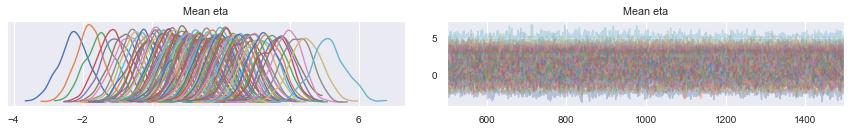

In [220]:
n_samples = 100
log_likelihood = RankMatchingGaussianKDELogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.UniformLogPrior(-10, 10)] * n_samples)
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
rmg_kde_100_posterior = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup = 500
thinning_ratio = 1
az.plot_trace(
    rmg_kde_100_posterior.sel(
        draw=slice(warmup, n_iterations, thinning_ratio)))
plt.tight_layout()

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     22     0.46875  8        0:00.3
1     23     0.25     1        0:00.3
2     33     0.455    5        0:00.5
3     35     0.333332 1        0:00.5
20    241    0.765    12       0:03.3
40    414    0.755    9        0:06.3
60    543    0.795    7        0:08.1
80    1056   0.83462  25       0:14.9
100   1357   0.732    15       0:19.1
120   1814   0.71     22       0:25.0
140   2202   0.761    19       0:30.9
160   2511   0.706    15       0:35.1
180   2881   0.746    18       0:39.9
200   3264   0.759    19       0:44.9
220   3623   0.766    18       0:49.8
240   3979   0.762    17       0:55.1
260   4327   0.732    17       0:59.7
280   4717   0.739    19       1:05.3
300   5033   0.759    16       1:09.5
320   5357   0.753    16       1:15.0
340   5705   0.755823 17       1:19.9
360   6036   0.751    16       1:24.1
380   6397   0.758    18       1:28.6
400   6743   0.772

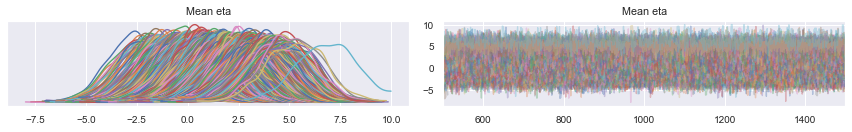

In [221]:
n_samples = 1000
log_likelihood = RankMatchingGaussianKDELogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.UniformLogPrior(-10, 10)] * n_samples)
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
rmg_kde_1000_posterior = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup = 500
thinning_ratio = 1
az.plot_trace(
    rmg_kde_1000_posterior.sel(
        draw=slice(warmup, n_iterations, thinning_ratio)))
plt.tight_layout()

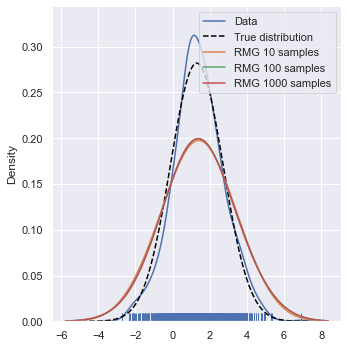

In [224]:
# Sample from Gaussian approximation
mean = true_parameters[0]
sigma = np.sqrt(true_parameters[1]**2 + true_parameters[2]**2)
mus = np.linspace(mean - 5 * sigma, mean + 5 * sigma, num=200)
true_pdf = scipy.stats.norm(mean, sigma).pdf(mus)

# Construct KDE fit
mu_samples = rmg_kde_10_posterior['Mean eta'].values[0, -1]
pdf_10_samples = np.empty(shape=(len(mu_samples), len(mus)))
kernel_size = np.std(data, ddof=1) * (4 / 3 / len(mu_samples)) ** (0.2)
for ids, mu in enumerate(mu_samples):
    pdf_10_samples[ids] = scipy.stats.norm(mu, sigma).pdf(mus)
pdf_10_samples = np.mean(pdf_10_samples, axis=0)

mu_samples = rmg_kde_100_posterior['Mean eta'].values[0, -1]
pdf_100_samples = np.empty(shape=(len(mu_samples), len(mus)))
kernel_size = np.std(data, ddof=1) * (4 / 3 / len(mu_samples)) ** (0.2)
for ids, mu in enumerate(mu_samples):
    pdf_100_samples[ids] = scipy.stats.norm(mu, sigma).pdf(mus)
indiv_pdf_100_samples = pdf_100_samples
pdf_100_samples = np.mean(pdf_100_samples, axis=0)

mu_samples = rmg_kde_1000_posterior['Mean eta'].values[0, -1]
pdf_1000_samples = np.empty(shape=(len(mu_samples), len(mus)))
kernel_size = np.std(data, ddof=1) * (4 / 3 / len(mu_samples)) ** (0.2)
for ids, mu in enumerate(mu_samples):
    pdf_1000_samples[ids] = scipy.stats.norm(mu, sigma).pdf(mus)
pdf_1000_samples = np.mean(pdf_1000_samples, axis=0)

# Visualse approximation and data
ax = sns.displot(data.flatten(), kind='kde', rug=True, label='Data')
plt.plot(
    mus, true_pdf, color='black', linestyle='dashed', label='True distribution')
plt.plot(mus, pdf_10_samples, color=colors[1], label='RMG 10 samples')
plt.plot(mus, pdf_100_samples, color=colors[2], label='RMG 100 samples')
plt.plot(mus, pdf_100_samples, color=colors[3], label='RMG 1000 samples')

plt.legend()
plt.show()

### 4. Generalised rank-matching algorithm

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     5      0.25     1        0:00.0
1     6      0.25     1        0:00.0
2     7      0.25     1        0:00.0
3     8      0.25     1        0:00.0
20    106    0.757    6        0:00.2
40    633    0.748    26       0:00.7
60    1033   0.755    20       0:01.1
80    1201   0.729    8        0:01.3
100   1372   0.747    8        0:01.5
120   1587   0.733    11       0:01.7
140   2039   0.749    22       0:02.2
160   2328   0.729    14       0:02.5
180   2716   0.736    19       0:02.9
200   3064   0.752    17       0:03.2
220   3384   0.749    16       0:03.5
240   3708   0.774    16       0:03.9
260   3922   0.68699  11       0:04.1
280   4086   0.764    8        0:04.3
300   4206   0.748    6        0:04.4
320   4318   0.771    6        0:04.5
340   4422   0.76     5        0:04.6
360   4526   0.729    5        0:04.7
380   4632   0.767    6        0:04.8
400   4752   0.735

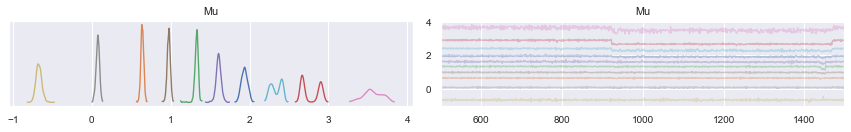

In [252]:
class CauchyKDELogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, n_samples=1000, kernel_scale=None):
        self._observations = observations.flatten()
        self._n_samples = int(n_samples)

        # Set kernel scale
        # (If None or non-positive use Scott's rule of thumb (like scipy))
        if (not kernel_scale) or (kernel_scale <=0):
            kernel_scale = \
                np.std(observations, ddof=1) \
                * (4 / 3 / self._n_samples) ** (0.2)
        self._kernel_scale = kernel_scale / self._n_samples

    def __call__(self, parameters):
        mu = np.array(parameters[:self._n_samples])

        score = np.sum(scipy.special.logsumexp(
            - np.log(np.pi * self._kernel_scale) + np.log(
                1 / (1 + (mu[np.newaxis, :] -
                self._observations[:, np.newaxis])**2 \
            / self._kernel_scale**2)), axis=1) - np.log(self._n_samples))

        return score

    def evaluateS1(self, parameters):
        mu = np.array(parameters[:self._n_samples])

        # Estimate log-likelihood as the mean across kdes
        scores = \
            - np.log(np.pi * self._kernel_scale) + np.log(
                1 / (1 + (mu[np.newaxis, :] -
                self._observations[:, np.newaxis])**2 \
            / self._kernel_scale**2))
        score = np.sum(
            scipy.special.logsumexp(scores, axis=1) - np.log(self._n_samples))

        # Collect sensitivities
        log_softmax = \
            scores - np.max(scores, axis=1)[:, np.newaxis] \
            - scipy.special.logsumexp(
            scores - np.max(scores, axis=1)[:, np.newaxis], axis=1
            )[:, np.newaxis]

        sensitivities = np.zeros(shape=self.n_parameters())
        sensitivities[:self._n_samples] = \
            - 2 / self._kernel_scale**2 * np.sum(
            (mu[np.newaxis, :] -
            self._observations[:, np.newaxis]) / (1 + (mu[np.newaxis, :] -
            self._observations[:, np.newaxis])**2 \
            / self._kernel_scale**2) * np.exp(log_softmax),
            axis=0)

        return score, sensitivities

    def n_parameters(self):
        return self._n_samples

    def get_parameter_names(self):
        return ['Mu'] * self._n_samples

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_samples)]


n_samples = 10
log_likelihood = CauchyKDELogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.UniformLogPrior(-10, 10)] * n_samples)
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
cauchy_kde_10_posterior = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup = 500
thinning_ratio = 1
az.plot_trace(
    cauchy_kde_10_posterior.sel(
        draw=slice(warmup, n_iterations, thinning_ratio)))
plt.tight_layout()

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     12     0.205    4        0:00.1
1     15     0.125    2        0:00.1
2     104    0.0129   45       0:00.6
3     231    0.49     64       0:01.3
20    5627   0.785    300      0:30.9
40    10545  0.74     235      0:56.6
60    13798  0.75422  155      1:11.6
80    17345  0.766    169      1:28.1
100   21348  0.744    191      1:47.1
120   27438  0.717    290      2:16.4
140   34407  0.747    332      2:54.5
160   44028  0.691    458      3:43.8
180   54801  0.78     513      4:37.0
200   66995  0.76     581      5:40.1
220   74212  0.742    344      6:17.1
240   82887  0.770719 414      7:01.1
260   85692  0.709    134      7:15.4
280   87170  0.736583 71       7:23.4
300   88580  0.786    68       7:30.3
320   90139  0.747    75       7:38.5
340   91525  0.75     66       7:45.2
360   93511  0.766    95       7:55.4
380   99789  0.717    299      8:25.6
400   105941  0.75

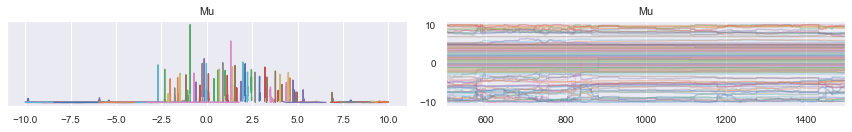

In [254]:
n_samples = 100
log_likelihood = CauchyKDELogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.UniformLogPrior(-10, 10)] * n_samples)
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
cauchy_kde_100_posterior = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup = 500
thinning_ratio = 1
az.plot_trace(
    cauchy_kde_100_posterior.sel(
        draw=slice(warmup, n_iterations, thinning_ratio)))
plt.tight_layout()

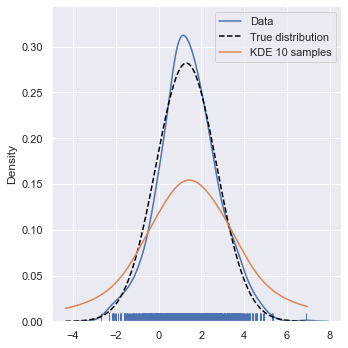

In [253]:
# Sample from Gaussian approximation
mean = true_parameters[0]
sigma = np.sqrt(true_parameters[1]**2 + true_parameters[2]**2)
mus = np.linspace(mean - 4 * sigma, mean + 4 * sigma, num=200)
true_pdf = scipy.stats.norm(mean, sigma).pdf(mus)

# Construct KDE fit
mu_samples = cauchy_kde_10_posterior.Mu.values[0, -1]
pdf_10_samples = np.empty(shape=(len(mu_samples), len(mus)))
kernel_size = np.std(data, ddof=1) * (4 / 3 / len(mu_samples)) ** (0.2)
for ids, mu in enumerate(mu_samples):
    pdf_10_samples[ids] = scipy.stats.cauchy(mu, sigma).pdf(mus)
indiv_pdf_10_samples = pdf_10_samples
pdf_10_samples = np.mean(pdf_10_samples, axis=0)

# mu_samples = gaussian_kde_100_posterior.Mu.values[0, -1]
# pdf_100_samples = np.empty(shape=(len(mu_samples), len(mus)))
# kernel_size = np.std(data, ddof=1) * (4 / 3 / len(mu_samples)) ** (0.2)
# for ids, mu in enumerate(mu_samples):
#     pdf_100_samples[ids] = scipy.stats.norm(mu, sigma).pdf(mus)
# pdf_100_samples = np.mean(pdf_100_samples, axis=0)

# mu_samples = gaussian_kde_1000_posterior.Mu.values[0, -1]
# pdf_1000_samples = np.empty(shape=(len(mu_samples), len(mus)))
# kernel_size = np.std(data, ddof=1) * (4 / 3 / len(mu_samples)) ** (0.2)
# for ids, mu in enumerate(mu_samples):
#     pdf_1000_samples[ids] = scipy.stats.norm(mu, sigma).pdf(mus)
# pdf_1000_samples = np.mean(pdf_1000_samples, axis=0)

# Visualse approximation and data
ax = sns.displot(data.flatten(), kind='kde', rug=True, label='Data')
plt.plot(mus, true_pdf, color='black', linestyle='dashed', label='True distribution')
plt.plot(mus, pdf_10_samples, color=colors[1], label='KDE 10 samples')
# plt.plot(mus, pdf_100_samples, color=colors[2], label='KDE 100 samples')
# for pdf in indiv_pdf_10_samples:
#     plt.plot(mus, pdf / 10, color=colors[1], linestyle='dashed')
# plt.plot(mus, pdf_1000_samples, color=colors[3], label='KDE 1000 samples')

plt.legend()
plt.show()